# Forewords

This notebook gathers the code for the evaluation of FINSURF performance through the analysis of the subset Genomizer variants devoid of HGMD-variants (not overlaping, and beyond 1kb of any HGMD variant used in the training of FINSURF).

These Genomizer variants are considered as a set of positive controls truly independent of the HGMD variants from FINSURF's training dataset.
In addition, negative controls are taken from a reference genome generated in the Illumina Platinum genomes, which we use here as a background distribution of variants as would be obtained in the context of a WGS of a patient.

The main analysis aimed at ranking the Genomizer variants among the Platinum variants, to show what kind of results can be expected from FINSURF.
In addition, we compare the performance of FINSURF against state-of-the-art methods, through different metrics and visualization : ROC / PRC, score distributions, etc.

# Init

## Imports

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import gzip
import functools

import pickle
import collections
import itertools as itt


from IPython.display import display

import pybedtools as pbt

if not os.path.exists("/localtmp/moyon/"):
    os.makedirs('/localtmp/moyon/')
    
pbt.set_tempdir("/localtmp/moyon/")

In [337]:
# Importing my libs
if not '/users/ldog/moyon/Thesis/scripts/' in sys.path:
    sys.path.insert(0,'/users/ldog/moyon/Thesis/scripts/')

import dataframes
import ML_visualization

if not '/users/ldog/moyon/Thesis/projects/FINSURF/annotToNumeric/' in sys.path:
    sys.path.insert(0, '/users/ldog/moyon/Thesis/projects/FINSURF/annotToNumeric/')
    
import annotToNumeric

if not '../../FINSURF/createModels/' in sys.path:
    sys.path.insert(0, '../../FINSURF/createModels/')
    
import model_comparison_lib

In [338]:
import matplotlib as mpl
mpl.rcParams.update({'figure.autolayout':True})
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.style.use('seaborn-notebook')

SMALL_SIZE=16
MEDIUM_SIZE=20
BIGGER_SIZE=22

mpl.rc('font',size=SMALL_SIZE)
mpl.rc('axes',titlesize=SMALL_SIZE)
mpl.rc('axes',labelsize=MEDIUM_SIZE)
mpl.rc('xtick',labelsize=SMALL_SIZE)
mpl.rc('ytick',labelsize=SMALL_SIZE)
mpl.rc('legend',fontsize=SMALL_SIZE)
mpl.rc('figure',titlesize=BIGGER_SIZE)

## Definitions

In [15]:
def coord_convert_to_Npts(value, max_value, Npts=100, log10=False, right_to_left=True):
    """ Convert rank value to a point location on the plot representation.
    
    Variants are to be represented as vertical bars overlaying a rectangle, which represent
    itself the full range of ranks.
    
    This function aims at converting the rank value to a coordinate over the rectangle.
    
    Arguments:
    - value (int) : 
    - max_value (int) : the total of variants over which each variant is ranked (ie the lowest rank possible)
    - Npts (int, default=100) : size in points of the rectangle that is drawn for representation of the range of ranks,
                                onto which the lines will be plotted.
    - log10 (bool, default=False) : whether the ranks are converted to log10 values or not
    - right_to_left (bool, default=True) : whether the top rank is the right-most position on the rectangle.
    
    Returns: float corresponding to the coordinate of the rank value on the rectangle.
    
    """
    if log10:
        new_coord = np.log10(value) * Npts / np.log10(max_value)
        
    else:
        new_coord = value*Npts/max_value
        
    
    if right_to_left :
        new_coord = Npts - new_coord

    return new_coord


def add_visual_ticks_aids(list_ticks, lowest_rank, ax,
                          width=1,
                          Npts=100,
                          log10=False,
                          right_to_left=True,
                          color='#FFFFFF'
                         ):
    """ Add vertical lines over a rectangle bar to serve as visual ticks aids.
    
    The ranking range of variants is represented as a colored rectangle, onto which
    are plotted vertical lines to highlight some variants of interest.
    To have a better idea of the ranks associated to these vertical line, we want to 
    plot additional vertical line that will higlight "major ticks" over the entire range
    (e.g. 10th rank, 50th rank, 1,000th rank, etc.)
    
    This function takes a list of such "highlight ranks" values, converts them to coordinates
    to be displayed on the rectangle, and adds them as vertical bars to the provided ax.
    
    Arguments:
    - list_ticks (list) : list of integer values corresponding to rank markers to display
    - lowest_rank (int) : corresponds to the total of variants ranked, ie the maximum, lowest rank a variant can get
    - ax (matplotlib.axes._subplots.AxesSubplot) : ax onto which to add the visual ticks.
    - width (float, default=1) : display parameter for the width of the vertical line to plot
    - Npts (int, default=100) : size in points of the rectangle that is drawn for representation of the range of ranks,
                                onto which the ranks will be plotted
    - log10 (bool, default=False) : whether the ranks are converted to log10 values or not
    - right_to_left (bool, default=True) : whether the top rank is the right-most position on the rectangle.
    
    """
    for v in list_ticks:
        hpos = coord_convert_to_Npts(v, lowest_rank, Npts,log10,right_to_left)
        ax.axvline(hpos, ymin=0, ymax=0.25, linewidth=width, color=color)      
        
    return

In [16]:
def plot_ranks(dataframe_ranks, colors_omim, colors_omim_lowalpha, subset_omim=None,figsize=None, savefig_file=None):
    """ Main function of the experiment for displaying ranks of variants over different ranges of ranks.
    
    
    Notes :
    - although the helper functions define above accept <log10> parameter, this was hardcoded here for simplicity.
      So the plots of the "full" and "regulatory regions" ranks are in log10 scale, each with its specific set of
      visual tick aids, and the ranks per omim are in linear scales.
    
    
    
    Arguments:
    - dataframe_ranks (pandas.DataFrame) : 
    - colors_omim (dict) : 
    - colors_omim_lowalpha (dict) :
    - subset_omim (list, default=None)
    - figsize (tuple, default=None)
    - savefig_file (str, default=None) : if provided, this should be a path to a file to export the plot.
    """
    if figsize is None:
        figsize=(14,8)
        
    fig = plt.figure(figsize=figsize)

    if subset_omim:
        n_axes = len(subset_omim)+3
    else:
        n_axes = dataframe_ranks['OMIM_ID'].unique().shape[0]+3

        
    # PLOT 1: TRIANGLE 
    # ----------------

    # Display a triangle to illustrate the progression of score from low to high.
    ax0 = fig.add_subplot(n_axes,1,1)

    triangle = plt.Polygon(((0,2),(0,2.02),(100,3),(100,1)), color='#666666')
    ax0.add_patch(triangle)
    ax0.set_xlim(0,100)
    ax0.set_ylim(0,4)
    ax0.axis('off')

    ax0.annotate('Bottom', xy=(0, 0),  xycoords='data',
                xytext=(0, 0), textcoords='data',
                horizontalalignment='center', verticalalignment='bottom'
                )

    ax0.annotate('Top', xy=(100, 0),  xycoords='data',
                xytext=(100, 0), textcoords='data',
                horizontalalignment='center', verticalalignment='bottom'
                )

    ax0.annotate('FINSURF score', xy=(50, 4),  xycoords='data',
                xytext=(50, 3), textcoords='data',
                horizontalalignment='center', verticalalignment='bottom'
                )

    # END PLOT 1
    # ----------
    

    # PLOT 2: RANKS OVER FULL DATASET 
    # -------------------------------
    

    tmp_sub = dataframe_ranks.loc[dataframe_ranks['subset']=='all_variants',:]

    ax1 = fig.add_subplot(n_axes,1,2)
    rect = mpl.patches.Rectangle((0,0),100,2,linewidth=1,facecolor='#BBBBBB')
    ax1.add_patch(rect)
    ax1.set_xlim(0,100)
    ax1.set_ylim(0,8)
    ax1.axis('off')

    # Add text on the x axis
    lowest_rank = tmp_sub['N_tot'].iloc[0]+1
    lowest_rank_str = '{:,}'.format(lowest_rank)
    highest_rank = 1
    highest_rank_str = '{:,}'.format(1)


    ax1.annotate(lowest_rank_str, xy=(0, 0),  xycoords='data',
                xytext=(0, -1), textcoords='data',
                horizontalalignment='center', verticalalignment='bottom',
                 fontsize=12
                )

    ax1.annotate(highest_rank_str, xy=(100, 0),  xycoords='data',
                xytext=(100, -1), textcoords='data',
                horizontalalignment='center', verticalalignment='bottom',
                 fontsize=12
                )
    
    # Add title on the left size
    ax1.annotate('All variants', xy=(0, 0),  xycoords='data',
                xytext=(-8, 0), textcoords='data',
                horizontalalignment='center', verticalalignment='bottom',
                 fontsize=16
                )

    # Let's add visual hints of the rank:
    # Here : logscale ticks ; hardcoded basing on the total of variants.
    list_ticks = [10,100,1000,10000,100_000,1_000_000]
    add_visual_ticks_aids(list_ticks, lowest_rank,
                          ax1, Npts=100,
                          log10=True, right_to_left=True,
                          color='#FFFFFF'
                         )
    
    # Here : normal scale ticks ; commented out because not visually interesting.
#     interval = 100_000
#     list_ticks = (range(highest_rank+1, lowest_rank, interval))
#     width = coord_convert_to_Npts(lowest_rank-1, lowest_rank, Npts,
#                                   log10,right_to_left)
                                  
#     width = 1 if width < 0 else width
#      add_visual_ticks_aids(list_ticks, lowest_rank,
#                           ax1, Npts=100,
#                           log10=False, right_to_left=True,
#                           color='#FFFFFF'
#                          )


    # Plotting variants as colored vertical lines.
    width = coord_convert_to_Npts(lowest_rank-1, lowest_rank, Npts=100,
                                   log10=True,right_to_left=True)
    width = 2 if width<2 else width
    
    for irow, var in tmp_sub.iterrows():
        var_hpos = coord_convert_to_Npts(var['rank'], lowest_rank, Npts=100, log10=True, right_to_left=True)
        var_col = colors_omim[var['OMIM_ID']]

        ax1.axvline(var_hpos, ymin=0, ymax=0.25, linewidth=width, color=var_col)

    # END PLOT 2
    # ----------
        
    # PLOT 3: RANKS OVER REGULATORY REGIONS
    # -------------------------------------
    
    # Repeat the previous plot of ranks over a single rectangle of rank range,
    # this time subsetting to the variants lying in FINSURF regulatory regions.
               
    tmp_sub = dataframe_ranks.loc[dataframe_ranks['subset']=='in_reg_regions',:]

    ax2 = fig.add_subplot(n_axes,1,3)
    rect = mpl.patches.Rectangle((0,0),100,2,linewidth=1,facecolor='#BBBBBB')
    ax2.add_patch(rect)
    ax2.set_xlim(0,100)
    ax2.set_ylim(0,8)
    ax2.axis('off')

    lowest_rank = tmp_sub['N_tot'].iloc[0]+1
    lowest_rank_str = '{:,}'.format(lowest_rank)
    highest_rank = 1
    highest_rank_str = '{:,}'.format(1)


    ax2.annotate(lowest_rank_str, xy=(0, 0),  xycoords='data',
                xytext=(0, -1), textcoords='data',
                #arrowprops=dict(facecolor='black', shrink=0.05),
                horizontalalignment='center', verticalalignment='bottom',
                 fontsize=12
                )

    ax2.annotate(highest_rank_str, xy=(100, 0),  xycoords='data',
                xytext=(100, -1), textcoords='data',
                #arrowprops=dict(facecolor='black', shrink=0.05),
                horizontalalignment='center', verticalalignment='bottom',
                 fontsize=12
                )
    
    

    # Add title on the left size
    ax2.annotate('In regulatory\nregions', xy=(0, 0),  xycoords='data',
                xytext=(-8, 0), textcoords='data',
                horizontalalignment='center', verticalalignment='bottom',
                 fontsize=16
                )

    # Add visual aids
    list_ticks = [10,100,1000,10000,100_000]
    add_visual_ticks_aids(list_ticks, lowest_rank,
                          ax2, Npts=100,
                          log10=True, right_to_left=True,
                          color='#FFFFFF'
                         )



    # Plotting variants as colored vertical lines.
    width = coord_convert_to_Npts(lowest_rank-1, lowest_rank, Npts=100,
                                   log10=True,right_to_left=True)
    width = 2 if width<2 else width
    
    for irow, var in tmp_sub.iterrows():
        var_hpos = coord_convert_to_Npts(var['rank'], lowest_rank, Npts=100, log10=True, right_to_left=True)
        var_col = colors_omim[var['OMIM_ID']]

        ax2.axvline(var_hpos, ymin=0, ymax=0.25, linewidth=width, color=var_col)


    # END PLOT 3
    # ----------
    
    
    # ADDITIONAL PLOTS : PER-DISEASE RANKING
    # --------------------------------------

    # Now process each disease : we make a colored bar that represents the ranks over all variants (negative + positive)
    # lying within regulatory regions associated with the disease gene(s).
    # The candidate variants are again represented as colored vertical bars, this time with an additional text annotation
    # that gives information on the variant (chrom, pos, etc.)
    
    if subset_omim is None:
        subset_omim = dataframe_ranks['OMIM_ID'].unique()
        
    for i, OMIM_ID in enumerate(subset_omim,start=1):
        print(OMIM_ID)
        tmp_sub = dataframe_ranks.loc[(dataframe_ranks['subset']=='in_disease_regions') & \
                                      (dataframe_ranks['OMIM_ID']==OMIM_ID)
                                      ,:]




        ax = fig.add_subplot(n_axes, 1, 3+i)
        rect = mpl.patches.Rectangle((0,0),100,2,linewidth=1,facecolor=colors_omim_lowalpha[OMIM_ID])
        ax.add_patch(rect)
        ax.set_xlim(0,100)
        ax.set_ylim(0,8)
        ax.axis('off')
        
        ax.annotate('Regulatory regions of disease {}'.format(OMIM_ID),
                    xy=(50, 0),  xycoords='data',
                    xytext=(50, -2.5), textcoords='data',
                    horizontalalignment='center', verticalalignment='bottom',
                    color=colors_omim[OMIM_ID],
                    fontsize=14
                    )

        lowest_rank = tmp_sub['N_tot'].iloc[0]+1
        lowest_rank_str = '{:,}'.format(lowest_rank)
        highest_rank = 1
        highest_rank_str = '{:,}'.format(1)


        ax.annotate(lowest_rank_str, xy=(0, 0),  xycoords='data',
                    xytext=(0, -1), textcoords='data',
                    horizontalalignment='center', verticalalignment='bottom',
                 fontsize=12
                    )

        ax.annotate(highest_rank_str, xy=(100, 0),  xycoords='data',
                    xytext=(100, -1), textcoords='data',
                    horizontalalignment='center', verticalalignment='bottom',
                 fontsize=12
                    )

        
        # Here : getting position parameters for the text annotation of variants.
        N_var = tmp_sub.shape[0]
        
        if N_var<4:
            xpos_texts = np.linspace(50,80,N_var)
        elif N_var<7:
            xpos_texts = np.linspace(30,80,N_var)
        else:
            xpos_texts = np.linspace(5,80,N_var)
        
        width = coord_convert_to_Npts(lowest_rank-1, lowest_rank, Npts=100,
                                   log10=False,right_to_left=True)
        print("\t{}".format(width))
        width = 2 if width<0 else width
        width *= 0.9 # To add some spacing between two adjacent variants.
        
        print("\t{}".format(width))
        
        for (irow, var), xpos_text in zip(tmp_sub.sort_values(by='score').iterrows(),xpos_texts):
            var_hpos = coord_convert_to_Npts(var['rank'], lowest_rank, Npts=100, log10=False, right_to_left=True)
            var_col = colors_omim[var['OMIM_ID']]

            # Better to work with rectangles than vertical lines here, as the ranges are much smaller
            # than previous plots, so we can have better control of width, height, etc.
            rect = mpl.patches.Rectangle((var_hpos,0),width,2,linewidth=0,facecolor=var_col)
            ax.add_patch(rect)
            
            # Let's add annotations.
            ax.annotate(var['var_str'],
                        xy=(var_hpos, 2), xycoords='data',
                        xytext=(xpos_text,4), textcoords='data',
                        arrowprops=dict(arrowstyle="->",
                                        connectionstyle='arc3,rad=-0.2',
                                        linewidth=1,
                                        color=var_col
                                       ),
                        fontsize=8,
                        color=colors_omim[OMIM_ID]
            )


        print("\n")
        
    # END PLOTS
    # ---------

    if savefig_file:
        plt.savefig(savefig_file)
        
    plt.show()

In [187]:
def create_regular_grid_axes(N_tot, N_cols, height_row, width):
    """ Create a figure with a grid of N_tot axes with N_cols.
    
    Given N_tot a number of axes to generate, and N_cols the maximum
    number of axes on a row, this function generates the list of axes
    with the correct layout.
    
    To define the size of the figure, height_row and width are used.
    
    In:
        N_tot (int):
        N_cols (int):
        height_row (int):
        width (int):
        
    Return:
        (fig, axs)
        
    """
    N_rows = N_tot // N_cols
    N_rows += N_tot % N_cols
    Position = range(1, N_tot+1)
    
    fig = plt.figure(figsize = (width, height_row * N_rows))
    axs = []
    for pos in Position:
        axs.append(fig.add_subplot(N_rows, N_cols, pos))
        
    return (fig, axs)

# Data loading

## Misc

In [3]:
path_biotype_importance = "/kingdoms/dyogen/workspace5/RegulationData/hg19/genome_annotations/gencode/v29lifthg19/metadata_tables/finale_biotypes_ordered.tsv"
biotype_importance = pd.read_table(path_biotype_importance).set_index('biotype')['importance'].to_dict()

path_biotype_simplification = "/kingdoms/dyogen/workspace5/RegulationData/hg19/genome_annotations/gencode/v29lifthg19/metadata_tables/gencode_simplified_biotypes_map.tsv"
biotype_simplified = pd.read_table(path_biotype_simplification).set_index('biotypes')['simplified_biotypes'].to_dict()

In [6]:
with open("../datasets/resources/2020-03-18_COMPLETE_JSON_OMIM-DISEASES.pckl", "rb") as input_omim:
    json_omim_str = pickle.load(input_omim)

In [14]:
colors_omim_complete = {
     'MIM 176100': {'normal': '#1b39d8', 'lowalpha': '#808eda'},
     'MIM 614167': {'normal': '#1875b4', 'lowalpha': '#70a3c6'},
     'MIM 610542': {'normal': '#047a38', 'lowalpha': '#80af86'},
     'MIM 608265': {'normal': '#2ea026', 'lowalpha': '#71b06d'},
     'MIM 613375': {'normal': '#fb9594', 'lowalpha': '#ffcbcb'},
     'MIM 609637': {'normal': '#e31012', 'lowalpha': '#fa8687'},
     'MIM 605714': {'normal': '#fdbc68', 'lowalpha': '#ffdeb4'},
     'MIM 137750': {'normal': '#ff7f00', 'lowalpha': '#ffbc79'},
     'MIM 236000': {'normal': '#c9b0d6', 'lowalpha': '#e4d7eb'},
     'MIM 611126': {'normal': '#68389a', 'lowalpha': '#8e74a9'},
     'MIM 614674': {'normal': '#d81b41', 'lowalpha': '#e27a8f'},
     'MIM 146550': {'normal': '#b15521', 'lowalpha': '#c39074'},
     'MIM 260000': {'normal': '#c2b200', 'lowalpha': '#dbd375'},
     'MIM 615922': {'normal': '#1875b4', 'lowalpha': '#70a3c6'},
     'MIM 605285': {'normal': '#79b346', 'lowalpha': '#b0df87'},
     'MIM 610024': {'normal': '#2ea026', 'lowalpha': '#71b06d'},
     'MIM 601952': {'normal': '#fb9594', 'lowalpha': '#ffcbcb'},
     'MIM 117650': {'normal': '#e31012', 'lowalpha': '#fa8687'},
     'MIM 300009': {'normal': '#fdbc68', 'lowalpha': '#ffdeb4'},
     'MIM 312080': {'normal': '#ff7f00', 'lowalpha': '#ffbc79'},
     'MIM 308240': {'normal': '#ce4545', 'lowalpha': '#dda2a2'},
     'MIM 119300': {'normal': '#68389a', 'lowalpha': '#8e74a9'},
     'MIM 124000': {'normal': '#068f7e', 'lowalpha': '#88e2d7'},
     'MIM 102200': {'normal': '#b15521', 'lowalpha': '#c39074'}, 
     'MIM 261800': {'normal': '#8800aa', 'lowalpha': '#c29fca'}, 
     'MIM 300751': {'normal': '#1875b4', 'lowalpha': '#70a3c6'},
     'MIM 606785': {'normal': '#00bbbb', 'lowalpha': '#9bcaca'}, 
     'MIM 175100': {'normal': '#2ea026', 'lowalpha': '#71b06d'},
     'MIM 207750': {'normal': '#fb9594', 'lowalpha': '#ffcbcb'},
     'MIM 308230': {'normal': '#e31012', 'lowalpha': '#fa8687'}
}

In [30]:
score_columns = ["CADD.score","FATHMM_MKL.score","NCBoost.score","ReMM.score","eigen.score","eigen.PC_score","fitcons","linsight"]

## FINSURF regions

In [4]:
path_finsurf_regions_TOFORMAT = "/users/ldog/moyon/Thesis/projects/merge_regulatory_regions/datasets/all_merged/raw/{}_merged.bed.gz"

chroms = ['chr{}'.format(i) for i in range(1,23)]+['chrX','chrY']

bt_regions_finsurf = {}
for chrom in chroms:
    bt_regions = pbt.BedTool(path_finsurf_regions_TOFORMAT.format(chrom))
    bt_regions_finsurf[chrom] = bt_regions                  

## Variants

### Genomizer

In [7]:
# Here : read the Genomizer variants (VCF + numeric)
path_vcf_genomizer = "../datasets/inputs/genomizer/filtered/00_full_dataset.vcf"
path_numeric_genomizer = "../datasets/inputs/genomizer/numeric/00_full_dataset.tsv.gz"
path_targets_genomizer = "../datasets/inputs/genomizer/numeric/00_full_dataset_GENES.tsv.gz"
path_scored_genomizer = "../datasets/inputs/genomizer/scored/00_full_dataset_NUM.tsv.gz"


vcf_genomizer = pd.read_table(path_vcf_genomizer)
numeric_genomizer = pd.read_table(path_numeric_genomizer)
numeric_genomizer['ratio_shared_targets'] = pd.read_table(path_targets_genomizer,
                                                          usecols=['ratio_shared_targets']).values
genes_genomizer = pd.read_table(path_targets_genomizer)

scored_genomizer = pd.read_table(path_scored_genomizer)

In [8]:
scored_genomizer.head()

,chrom,start,end,id,ref,alt,row_id,CADD.score,FATHMM_MKL.score,NCBoost.score,ReMM.score,b_score,eigen.score,eigen.PC_score,fitcons,linsight,fire.score,gnomadAF.AF
0,chr1,11083407,11083408,.,G,A,chr1_0,1.918299,0.93266,0.298746,0.954,395.0,1.47500,0.15860,0.256867,0.555177,0.538,NaN
1,chr1,26143315,26143316,.,T,C,chr1_1,2.057273,0.92260,0.698329,0.977,433.0,1.41200,0.05847,0.322412,0.817933,0.882,NaN
2,chr1,45481172,45481173,.,G,T,chr1_2,-0.118455,0.24744,0.091849,0.023,132.0,-0.09048,-0.05699,0.295142,0.267471,0.971,NaN
3,chr1,91381762,91381763,.,C,T,chr1_3,1.404535,0.98957,0.400861,0.907,438.0,1.66300,0.08922,0.322412,0.973077,0.534,NaN
4,chr1,91382342,91382343,.,G,C,chr1_4,1.003147,0.97702,0.163355,0.858,433.0,1.42200,0.06357,0.295142,0.344494,0.678,NaN


Let's map each row ID to the best score among its scored bases, for each of the scores.

In [31]:
mapping_rowid_score_genomizer = {}

for sc in score_columns:
    print(sc)
    tmp_nodup = scored_genomizer.loc[~scored_genomizer['row_id'].duplicated(keep=False),["row_id",sc]]
    tmp_dup = scored_genomizer.loc[scored_genomizer['row_id'].duplicated(keep=False),
                                   ["row_id",sc]].sort_values(by=["row_id",sc],ascending=[True,False]
                                                             ).drop_duplicates(subset="row_id",keep="first")
    
    tmp = pd.concat([tmp_nodup,tmp_dup],axis=0)

    mapping_rowid_score_genomizer[sc] = tmp.set_index('row_id')[sc].to_dict()

CADD.score
FATHMM_MKL.score
NCBoost.score
ReMM.score
eigen.score
eigen.PC_score
fitcons
linsight


### Platinum

In [ ]:
path_vcf_platinum_77 = "../datasets/inputs/platinum/raw/NA12877.vcf.gz"
path_num_platinum_77 = "../datasets/inputs/platinum/numeric/NA12877.tsv.gz"
path_genes_platinum_77 = "../datasets/inputs/platinum/numeric/NA12877_GENES.tsv.gz"


#vcf_platinum_77 = pd.read_table(path_vcf_platinum_77,
#                                comment='#',
#                                header=None)
#vcf_platinum_77.columns = ['#chrom','pos','id','ref','alt','qual','filters','info','gt','alleles']


num_platinum_77 = pd.read_table(path_num_platinum_77)
genes_platinum_77 = pd.read_table(path_genes_platinum_77)
num_platinum_77['ratio_shared_targets'] = genes_platinum_77['ratio_shared_targets'].values



In [ ]:
# TODO All this step of scoring the variants should be in a separate process

if not os.path.exists(path_scored_platinum_77):
    print("MAKING PREDICTIONS")
    # Create the scores
    platinum_77_scores = model.predict_proba(num_platinum_77.loc[:,model_cols])
    num_platinum_77['score'] = platinum_77_scores[:,1]
    
    
    num_platinum_77.loc[:,["chrom","start","end","ref","alt","row_id","score"]
                   ].to_csv(path_scored_platinum_77,
                              header=True,
                              index=False, sep="\t",
                               compression="gzip")
    
    
else:
    num_platinum_77['score'] = scored_platinum_77["score"]
    

In [11]:
path_scored_platinum_77 = "../datasets/inputs/platinum/scored/NA12977_FINSURF-SCORED.tsv.gz"
path_scored_OTHER_platinum_77 = "../datasets/inputs/platinum/scored/NA12977_NUM.tsv.gz"

scored_platinum_77 = pd.read_csv(path_scored_platinum_77,
                                   header=0,
                                   sep="\t"
                                  )

scored_platinum_77_OTHERS = pd.read_csv(path_scored_OTHER_platinum_77,
                                   header=0,
                                   sep="\t"
                                  )

In [32]:
mapping_rowid_score_platinum = {}

for sc in score_columns:
    print(sc)
    tmp_nodup = scored_platinum_77_OTHERS.loc[~scored_platinum_77_OTHERS['row_id'].duplicated(keep=False),["row_id",sc]]
    tmp_dup = scored_platinum_77_OTHERS.loc[scored_platinum_77_OTHERS['row_id'].duplicated(keep=False),
                                   ["row_id",sc]].sort_values(by=["row_id",sc],ascending=[True,False]
                                                             ).drop_duplicates(subset="row_id",keep="first")
    
    tmp = pd.concat([tmp_nodup,tmp_dup],axis=0)

    mapping_rowid_score_platinum[sc] = tmp.set_index('row_id')[sc].to_dict()

CADD.score
FATHMM_MKL.score
NCBoost.score
ReMM.score
eigen.score
eigen.PC_score
fitcons
linsight


## Results tables : Genomizer + Platinum

These tables correspond to the preprocessing of the Genomizer variants combined with Platinum variants :

- keeping the best FINSURF score per variants (for INS DEL or INDEL)
- annotating the regulatory region and level of association to disease gene
- formatting of the table

In [10]:
input_path_tables = "../results/per_omim_genomizer_with_platinum_tables/"

processed_tables_variants = {}

for omim_table in os.listdir(input_path_tables):
    omim_ID = omim_table.split(".")[0]
    print(omim_ID)
    processed_tables_variants[omim_ID] = pd.read_csv(input_path_tables+omim_table, sep="\t")

MIM_102200


/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (5,6,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


MIM_117650
MIM_119300
MIM_124000
MIM_137750
MIM_146550
MIM_175100
MIM_176100
MIM_207750
MIM_236000
MIM_260000
MIM_261800
MIM_300009
MIM_300751
MIM_308230
MIM_308240
MIM_312080
MIM_601952
MIM_605285
MIM_605714
MIM_606785
MIM_608265
MIM_609637
MIM_610024
MIM_610542
MIM_611126
MIM_613375
MIM_614167
MIM_614674
MIM_615922


In [326]:
processed_tables_variants["MIM_605714"].head(3)

,#chrom,pos,id,ref,alt,gene,omim,row_id,score,extracted_biotype,link_level_to_HGMDvariants,reg_info,association_to_disease_gene,varclass
0,chr21,27253648,.,AAT,A,APP,MIM 605714,chr21_38,0.836435,3UTR,variant >1kb HGMD ; gene SEEN,NaN,bestBiotype,DISEASE
1,chr1,126113,.,C,A,NaN,NaN,chr1_0,0.079041,intergenic,NaN,.,not_in_regulatoryRegion,CTRL
2,chr1,535131,.,T,G,NaN,NaN,chr1_1,0.031099,transcribed_processed_pseudogene,NaN,.,not_in_regulatoryRegion,CTRL


In addition we have a "summary table" that reports only the results fo the ranking experiment for the Genomizer variants.

In [17]:
summary_table_known_genes = pd.read_csv("../results/summary_table_known_genes.tsv.gz",
                                        sep="\t"
                                       )

In [328]:
display(summary_table_known_genes.head(8))

,#chrom,pos,id,ref,alt,omim,gene,row_id,score,extracted_biotype,association_to_disease_gene,RANK,subset,N_tot,var_str
0,chr1,45481173,.,G,T,MIM 176100,UROD,chr1_2,0.141630,3UTR,bestBiotype,717537,all_variants,4016600,"chr1:45481173:G>T\nScore=0.142 ; rank=717,538\..."
1,chr1,45481173,.,G,T,MIM 176100,UROD,chr1_2,0.141630,3UTR,bestBiotype,285298,in_reg_regions,604224,"chr1:45481173:G>T\nScore=0.142 ; rank=285,299\..."
2,chr1,45481173,.,G,T,MIM 176100,UROD,chr1_2,0.141630,3UTR,bestBiotype,49,in_disease_regions,74,chr1:45481173:G>T\nScore=0.142 ; rank=50\n(bes...
3,chr1,91381763,.,C,T,MIM 614167,ZNF644,chr1_3,0.709847,3UTR,bestBiotype,9214,all_variants,4016601,"chr1:91381763:C>T\nScore=0.71 ; rank=9,215\n(b..."
4,chr1,91382343,.,G,C,MIM 614167,ZNF644,chr1_4,0.519680,3UTR,bestBiotype,37070,all_variants,4016601,"chr1:91382343:G>C\nScore=0.52 ; rank=37,071\n(..."
5,chr1,91381763,.,C,T,MIM 614167,ZNF644,chr1_3,0.709847,3UTR,bestBiotype,5883,in_reg_regions,604225,"chr1:91381763:C>T\nScore=0.71 ; rank=5,884\n(b..."
6,chr1,91382343,.,G,C,MIM 614167,ZNF644,chr1_4,0.519680,3UTR,bestBiotype,22022,in_reg_regions,604225,"chr1:91382343:G>C\nScore=0.52 ; rank=22,023\n(..."
7,chr1,91381763,.,C,T,MIM 614167,ZNF644,chr1_3,0.709847,3UTR,bestBiotype,4,in_disease_regions,42,chr1:91381763:C>T\nScore=0.71 ; rank=5\n(bestB...


# Preliminary : some info

## OMIM IDs to description

In [18]:
for omim_id in summary_table_known_genes.loc[summary_table_known_genes["subset"]=="in_disease_regions","omim"].unique():
    print(omim_id, json_omim_str[omim_id]["title"])

MIM 176100 PORPHYRIA CUTANEA TARDA
MIM 614167 MYOPIA 21, AUTOSOMAL DOMINANT; MYP21
MIM 610542 MYASTHENIC SYNDROME, CONGENITAL, 12; CMS12
MIM 608265 DEAFNESS, AUTOSOMAL RECESSIVE 39; DFNB39
MIM 613375 MATURITY-ONSET DIABETES OF THE YOUNG, TYPE 11; MODY11
MIM 609637 HOLOPROSENCEPHALY 5; HPE5
MIM 605714 CEREBRAL AMYLOID ANGIOPATHY, APP-RELATED
MIM 137750 GLAUCOMA 1, OPEN ANGLE, A; GLC1A
MIM 236000 LYMPHOMA, HODGKIN, CLASSIC; CHL
MIM 611126 MITOCHONDRIAL COMPLEX I DEFICIENCY, NUCLEAR TYPE 20; MC1DN20
MIM 614674 PERIODIC FEVER, MENSTRUAL CYCLE-DEPENDENT
MIM 146550 HYPOTRICHOSIS 4; HYPT4
MIM 260000 HYPEROXALURIA, PRIMARY, TYPE II; HP2
MIM 615922 RETINITIS PIGMENTOSA 70; RP70
MIM 605285 NEUROPATHY, HEREDITARY MOTOR AND SENSORY, RUSSE TYPE; HMSNR
MIM 610024 RETINAL CONE DYSTROPHY 3A; RCD3A
MIM 601952 KERATOSIS LINEARIS WITH ICHTHYOSIS CONGENITA AND SCLEROSING KERATODERMA; KLICK
MIM 117650 CEREBROCOSTOMANDIBULAR SYNDROME; CCMS
MIM 300009 DENT DISEASE 1
MIM 312080 PELIZAEUS-MERZBACHER DISEASE; P

## Genomizer variants not associated to the disease gene

For two OMIM, the Genomizer disease variants were not found within regulatory regions that target the OMIM disease gene.

In [22]:
# First OMIM with variants not in regulatory regions of the gene.
display(
    summary_table_known_genes.loc[(summary_table_known_genes["omim"]=="MIM 613375") & (summary_table_known_genes["subset"]=="in_disease_regions"),
                              :]
)

display(vcf_genomizer.loc[vcf_genomizer["omim"]=="MIM 613375",:])

,#chrom,pos,id,ref,alt,omim,gene,row_id,score,extracted_biotype,association_to_disease_gene,RANK,subset,N_tot,var_str
22,chr8,11422122,.,G,T,MIM 613375,BLK,chr8_14,0.461876,antisense,closest_gene,33,in_disease_regions,446,chr8:11422122:G>T\nScore=0.462 ; rank=34\n(clo...
23,chr8,11331747,.,G,T,MIM 613375,BLK,chr8_217,0.242558,intergenic,closest_gene,148,in_disease_regions,446,chr8:11331747:G>T\nScore=0.243 ; rank=149\n(cl...


,#chrom,pos,id,ref,alt,gene,omim,pmid
14,chr8,11422122,.,G,T,BLK,MIM 613375,19667185
217,chr8,11331747,.,G,T,BLK,MIM 613375,19667185


In [23]:
# Second OMIM with variants not in regulatory regions of the gene.
display(
    summary_table_known_genes.loc[(summary_table_known_genes["omim"]=="MIM 261800") & (summary_table_known_genes["subset"]=="in_disease_regions"),
                              :]
)

display(vcf_genomizer.loc[vcf_genomizer["omim"]=="MIM 261800",:])

,#chrom,pos,id,ref,alt,omim,gene,row_id,score,extracted_biotype,association_to_disease_gene,RANK,subset,N_tot,var_str
131,chr17,68676303,.,T,C,MIM 261800,SOX9,chr17_232,0.808298,intergenic,not_associated,3,in_disease_regions,132,chr17:68676303:T>C\nScore=0.808 ; rank=4\n(not...


,#chrom,pos,id,ref,alt,gene,omim,pmid
232,chr17,68676303,.,T,C,SOX9,MIM 261800,19234473


## Percentage of Genomizer variants in top X percents

In [330]:
thresholds_percentage_topXperc = [0.1,0.5,1,5,10,15,20,25,30,40,50]

### In regulatory regions

In [333]:
# Percentage of Genomizer in the top X percent for variants Regulatory regions

# Here : calculate for each Genomizer variants what % its rank is among the Regulatory Regions variants.
tmp_perc_rank_inRegReg = summary_table_known_genes.loc[summary_table_known_genes["subset"]=="in_reg_regions",:
                                                      ].apply(lambda row: row["RANK"] / (row["N_tot"]) *100, axis=1)

print("Number of Genomizer variants with rank % below threshold, considering Regulatory Regions")
display(
    pd.Series(
              [(tmp_perc_rank_inRegReg.values<=thresh_perc).sum() for thresh_perc in thresholds_percentage_topXperc],
             index=thresholds_percentage_topXperc
             ).to_frame().reset_index().set_axis(["top X % threshold","N Genomizer below threshold"],axis=1, inplace=False
                                                ).assign(Genomizer_percentage=lambda df: df["N Genomizer below threshold"]/49*100)
)


Number of Genomizer variants with rank % below threshold, considering Regulatory Regions


,top X % threshold,N Genomizer below threshold,Genomizer_percentage
0,0.1,10,20.408163
1,0.5,26,53.061224
2,1.0,28,57.142857
3,5.0,36,73.469388
4,10.0,40,81.632653
5,15.0,40,81.632653
6,20.0,42,85.714286
7,25.0,43,87.755102
8,30.0,43,87.755102
9,40.0,43,87.755102


### Over total set of Platinum variants

In [329]:
# Percentage of Genomizer in the top X percent for all Platinum

tmp_perc_rank_Tot = summary_table_known_genes.loc[summary_table_known_genes["subset"]=="all_variants",:
                                                      ].apply(lambda row: row["RANK"] / (row["N_tot"]) *100, axis=1)

print("Number of Genomizer variants with rank % below threshold, considering All Variants")
display(
    pd.Series(
              [(tmp_perc_rank_Tot.values<=thresh_perc).sum() for thresh_perc in thresholds_percentage_topXperc],
             index=thresholds_percentage_topXperc
             ).to_frame().reset_index().set_axis(["top X % threshold","N Genomizer below threshold"],axis=1, inplace=False
                                                ).assign(Genomizer_percentage=lambda df: df["N Genomizer below threshold"]/49*100)
)


Number of Genomizer variants with rank % below threshold, considering All Variants


,top X % threshold,N Genomizer below threshold,Genomizer_percentage
0,0.1,24,48.979592
1,0.5,29,59.183673
2,1.0,33,67.346939
3,5.0,40,81.632653
4,10.0,43,87.755102
5,15.0,43,87.755102
6,20.0,47,95.918367
7,25.0,47,95.918367
8,30.0,47,95.918367
9,40.0,49,100.000000


# Experiment visualizations

The goal here is to have for each disease the ranked Genomizer variants, when compared to the Platinum variants, as if they were obtained from the WGS of a patient.

## FINSURF : full evaluation of ranks

In [19]:
# Here : add a string description of each variant.
summary_table_known_genes['var_str'] = (summary_table_known_genes['#chrom']+':'+summary_table_known_genes['pos'].astype(str)+':'+\
                                        summary_table_known_genes['ref']+'>'+summary_table_known_genes['alt']+'\nScore='+\
                                        summary_table_known_genes['score'].apply(lambda v: '{:.3}'.format(v))+\
                                        ' ; '+\
                                        summary_table_known_genes['RANK'].apply(lambda v: 'rank={:,}'.format(v+1))+\
                                        "\n("+\
                                        summary_table_known_genes["association_to_disease_gene"]+\
                                        ')'
                                       ).values

tmp_for_plot = summary_table_known_genes.loc[:,['var_str','omim','score','subset','RANK','N_tot']
                             ].rename(columns={'omim':'OMIM_ID','RANK':'rank'})

As shown below, for the OMIM ID 614167, we have two variants ; each has its own rank in the three rankings (total Platinum, Regulatory Platinum, Disease Regulatory Platinum)

In [20]:
display(tmp_for_plot.loc[tmp_for_plot['OMIM_ID']=='MIM 614167'])

,var_str,OMIM_ID,score,subset,rank,N_tot
3,"chr1:91381763:C>T\nScore=0.71 ; rank=9,215\n(b...",MIM 614167,0.709847,all_variants,9214,4016601
4,"chr1:91382343:G>C\nScore=0.52 ; rank=37,071\n(...",MIM 614167,0.519680,all_variants,37070,4016601
5,"chr1:91381763:C>T\nScore=0.71 ; rank=5,884\n(b...",MIM 614167,0.709847,in_reg_regions,5883,604225
6,"chr1:91382343:G>C\nScore=0.52 ; rank=22,023\n(...",MIM 614167,0.519680,in_reg_regions,22022,604225
7,chr1:91381763:C>T\nScore=0.71 ; rank=5\n(bestB...,MIM 614167,0.709847,in_disease_regions,4,42
8,chr1:91382343:G>C\nScore=0.52 ; rank=9\n(bestB...,MIM 614167,0.519680,in_disease_regions,8,42


We now generate the plot (the float values serve for manual verification of the coordinate conversion for displaying correctly variants on the rectangles).

MIM 176100
	1.3333333333333286
	1.1999999999999957


MIM 614167
	2.3255813953488342
	2.093023255813951


MIM 610542
	0.6849315068493098
	0.6164383561643788


MIM 608265
	1.8867924528301927
	1.6981132075471734


MIM 613375
	0.2237136465324454
	0.20134228187920086


MIM 609637
	1.7241379310344769
	1.5517241379310291


MIM 605714
	0.23364485981308292
	0.21028037383177464


MIM 137750
	1.1904761904761898
	1.071428571428571


MIM 236000
	1.9607843137254832
	1.764705882352935


MIM 611126
	1.098901098901095
	0.9890109890109855


MIM 614674
	5.0
	4.5


MIM 146550
	1.3513513513513544
	1.2162162162162191


MIM 260000
	1.9607843137254832
	1.764705882352935


MIM 615922
	0.3344481605351177
	0.301003344481606


MIM 605285
	0.42735042735043294
	0.38461538461538963


MIM 610024
	0.6666666666666714
	0.6000000000000043


MIM 601952
	0.8771929824561369
	0.7894736842105232


MIM 117650
	1.2048192771084274
	1.0843373493975847


MIM 300009
	3.125
	2.8125


MIM 312080
	3.5714285714285694
	3.214285714285712

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


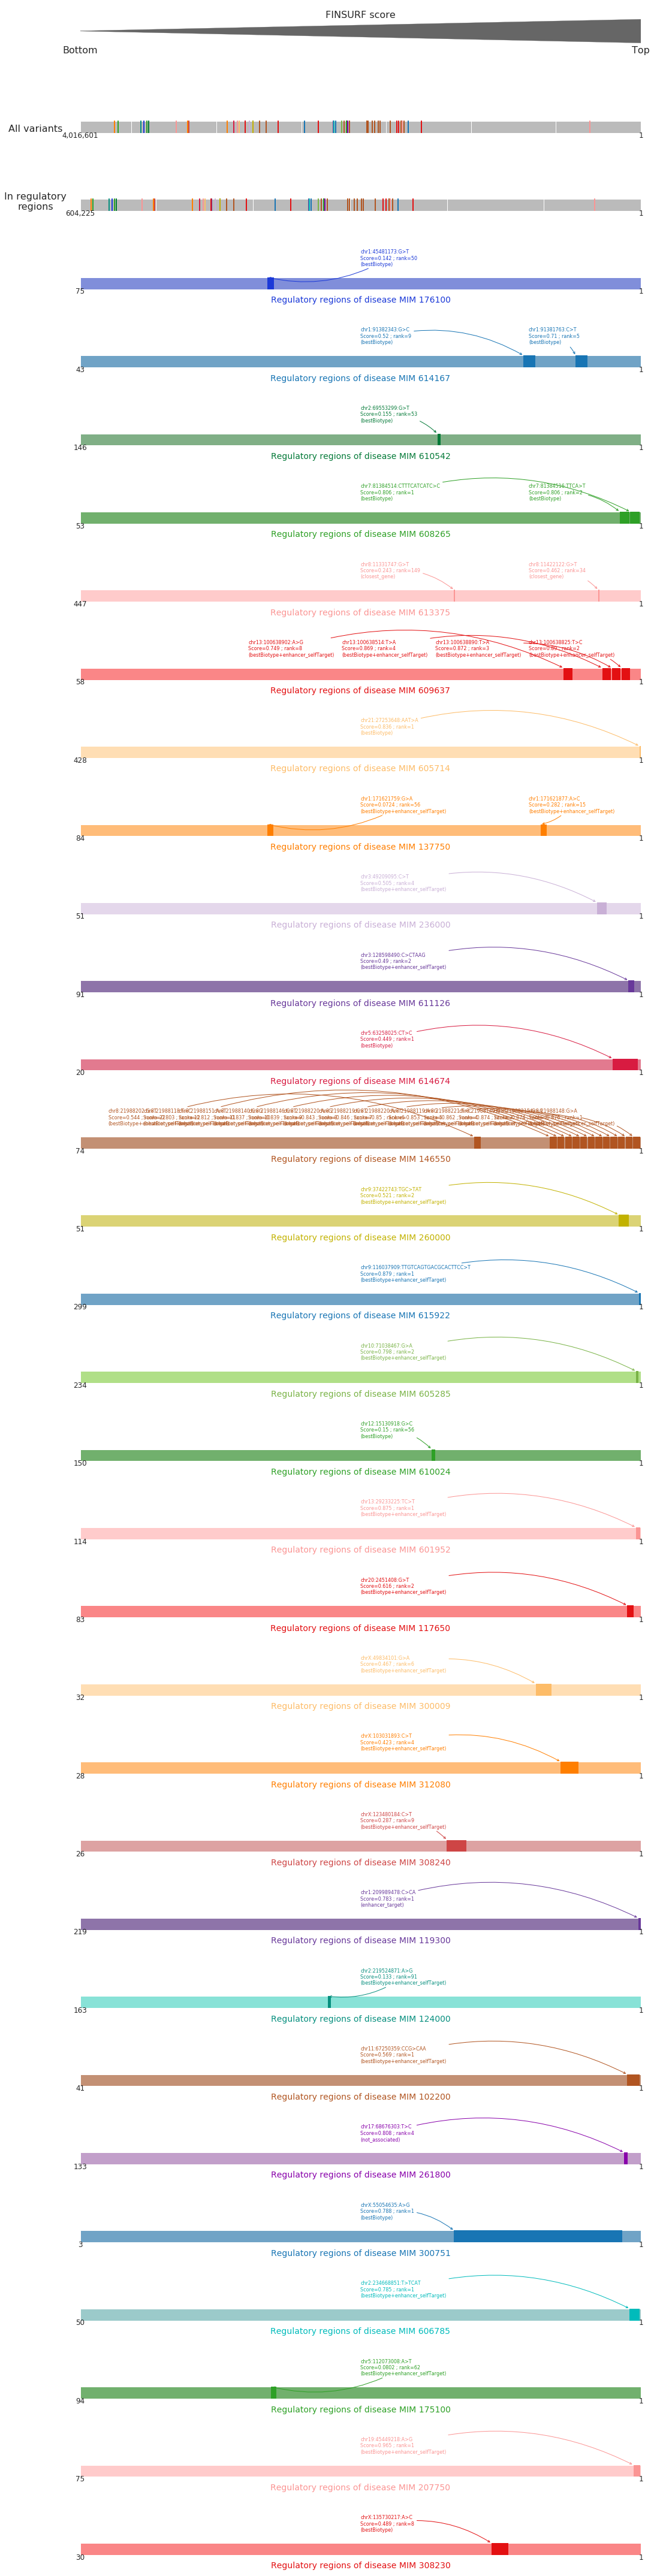

In [21]:
plot_ranks(tmp_for_plot.assign(rank=lambda df: df['rank']+1),
           #subset_omim=list(colors_omim_complete.keys())[:4],
           colors_omim={k:v['normal'] for k,v in colors_omim_complete.items()},
           colors_omim_lowalpha={k:v['lowalpha'] for k,v in colors_omim_complete.items()},
           figsize=(14,60),
           #savefig_file="./2020-03-18_genomizer-indep-variants_30-OMIM_FINSURF-ranks.svg"
          )

## Comparison to other scoring methods

Here we use the processed OMIM tables to retrieve the variants (both genomizer and platinum) in the disease-gene-associated regions.

For each alternative scoring method:
- we map the best score associated to the row_id of the variant, both for the genomizer variant and the platinum variants
- we get the rank of the disease variant among platinum variants in these disease-gene-associated regions

**Caution : missing scores**

- some of the variants will not be scored by all methods. For the figure we will only keep the variants that are scored by all methods.
- this means the **ranks will not be the same as in the figure above** ; so we need to recompute the ranks from FINSURF scores, to compare all methods on the same basis (same problem as the ROC / PRC not being the same between the cross-validation evaluation and the method comparison on this same cross-validation data.)

The goal is to try to provide with a visualization of the change in ranks of the genomizer variants when considering FINSURF vs other methods.

In addition, as we have "positive" and "negative" controls, we can work on more classic visualizations such as ROC and PRCs, etc.

**Figure Suggestions**

- **change in rank** : all Genomizer variants are represented in a pointplot, displaying their relative rank compared to the FINSURF-score rank. Increase in rank means that there are more control variants with better score.

- **Proportion of Genomizer variants per rank percentile** : calculate for the Genomizer variants their rank in each disease ; normalize it ; count the number of variants per normalized-rank percentile ; do it for each method

- (equivalent) : **Proportion of Platinum variants with score equal or higher** to the Genomizer variant for each disease.
  - Note : here we could actually filter variants *per score*, hence a variant that misses only one of the scores is dropped only for this score, and kept for ranking in the others
  - **we don't do that** : to compare all methods altogether, we want to evaluate them on the same basis.

- ROC / PRC

- Scatter plot of ROC and PRC AUCs

### Prepare data : filter out variants with missing scores

Let's do the filtering of variants by removing variants that are missing a score from **any** method.

In [27]:
display(processed_tables_variants[omim_ID].head(3))

,#chrom,pos,id,ref,alt,gene,omim,row_id,score,extracted_biotype,link_level_to_HGMDvariants,reg_info,association_to_disease_gene,varclass
0,chr9,116037909,.,TTGTCAGTGACGCACTTCC,T,PRPF4,MIM 615922,chr9_93,0.879457,5UTR,variant >1kb HGMD ; gene NOT SEEN,NaN,bestBiotype+enhancer_selfTarget,DISEASE
1,chr1,126113,.,C,A,NaN,NaN,chr1_0,0.079041,intergenic,NaN,.,not_in_regulatoryRegion,CTRL
2,chr1,535131,.,T,G,NaN,NaN,chr1_1,0.031099,transcribed_processed_pseudogene,NaN,.,not_in_regulatoryRegion,CTRL


In [44]:
# Those annotations correspond to an association of the variant to the gene of interest
# either by being located in the gene, or in a regulatory annotation.
disease_association_categories = ["enhancer_target","bestBiotype",
                                  "bestBiotype+enhancer_selfTarget",
                                  "notBestBiotype",
                                  "notBestBiotype+enhancer_selfTarget"]

In [75]:
results_alt_scores = {}
results_proportions_higher = {}
MISSING_GENOMIZER_SCORE = {}
DROPPED_OMIMs = []

ctrl_dropped = {}


for omim_id in processed_tables_variants.keys():
    print("#"*20)
    print(omim_id)
    
    tmp_df = processed_tables_variants[omim_id]
    
    # Isolate Genomizer variants
    sub_tbl_disease = tmp_df.loc[(tmp_df['varclass']=="DISEASE").values,:].copy()
    
    # Isolate control variants in disease regions.
    sub_tbl_ctrl = tmp_df.loc[((tmp_df['varclass']=="CTRL") & \
                               (tmp_df['association_to_disease_gene'].isin(disease_association_categories))
                              ).values,
                               :].copy()
    
    # Let's add the scores to Genomizer.
    for sc in mapping_rowid_score_genomizer.keys():
        sub_tbl_disease[sc] = sub_tbl_disease['row_id'].map(mapping_rowid_score_genomizer[sc])
        
    # We check if any of the genomizer variants are missing a score in any method.
    disease_missing_any_score = sub_tbl_disease.loc[:,score_columns].isnull().any(axis=1)
    
    if disease_missing_any_score.any():
        print(("Caution : {} Genomizer variants are missing at least one score for omim {}"
              ).format(disease_missing_any_score.sum(), omim_id)
             )
        MISSING_GENOMIZER_SCORE[omim_id] = sub_tbl_disease.loc[disease_missing_any_score,:]
        if disease_missing_any_score.all():
            print("No Genomizer left... dropping the OMIM ID")
            DROPPED_OMIMs.append(omim_id)
            continue
            
    sub_tbl_disease = sub_tbl_disease.loc[~disease_missing_any_score,:]
    
   
    # Let's add the scores to controls
    for sc in mapping_rowid_score_platinum.keys():
        sub_tbl_ctrl[sc] = sub_tbl_ctrl['row_id'].map(mapping_rowid_score_platinum[sc])
        
    # We check if any of the control variants are missing a score in any method.
    # Here we do not stop unless there is no control any more...
    ctrl_missing_any_score = sub_tbl_ctrl.loc[:,score_columns].isnull().any(axis=1)
    
    # Store information on missing variants over total of variants in the regulatory region.
    ctrl_missing[omim_id] = (ctrl_missing_any_score.sum(),sub_tbl_ctrl.shape[0])
    
    print("Total controls in disease regions : {:,}".format(sub_tbl_ctrl.shape[0]))
    print("\tof which {:,} are missing one of the scores (thus dropped)".format(ctrl_missing_any_score.sum()))
    if ctrl_missing_any_score.all():
        print("No control left... dropping the OMIM ID")
        DROPPED_OMIMs.append(omim_id)
        continue
        
    sub_tbl_ctrl = sub_tbl_ctrl.loc[~ctrl_missing_any_score.values,:]
    
    # Now calculate the fraction of the control variants that have a score equal or higher to each of the genomizer variants.
    # We copy the table of genomizer variants, and for each score (+finsurf score, column "score"), we replace the score
    # by the proportion of control variants that have a score equal or higher.
    
    result_disease = sub_tbl_disease.copy()
    for sc in ['score']+score_columns:
        props = []
        for disease_score in result_disease[sc].values:
            prop = (sub_tbl_ctrl[sc] >= disease_score).sum()/sub_tbl_ctrl.shape[0]
            props.append(prop)
            
        result_disease[sc] = props
           

    results_proportions_higher[omim_id] = result_disease
    results_alt_scores[omim_id] = pd.concat([sub_tbl_disease, sub_tbl_ctrl])
    
    print("\n\n")

####################
MIM_102200
Total controls in disease regions : 33
	of which 20 are missing one of the scores (thus dropped)



####################
MIM_117650
Total controls in disease regions : 72
	of which 50 are missing one of the scores (thus dropped)



####################
MIM_119300
Caution : 1 Genomizer variants are missing at least one score for omim MIM_119300
No Genomizer left... dropping the OMIM ID
####################
MIM_124000
Total controls in disease regions : 161
	of which 44 are missing one of the scores (thus dropped)



####################
MIM_137750
Total controls in disease regions : 67
	of which 38 are missing one of the scores (thus dropped)



####################
MIM_146550
Total controls in disease regions : 46
	of which 19 are missing one of the scores (thus dropped)



####################
MIM_175100
Total controls in disease regions : 75
	of which 41 are missing one of the scores (thus dropped)



####################
MIM_176100
Total controls in d

In [164]:
for k in ctrl_dropped.keys():
    print(f"{k}: N dropped = {ctrl_dropped[k][0]} / {ctrl_dropped[k][1]} ({ctrl_dropped[k][0]/ctrl_dropped[k][1]:.2%})")

MIM_102200: N dropped = 20 / 33 (60.61%)
MIM_117650: N dropped = 50 / 72 (69.44%)
MIM_124000: N dropped = 44 / 161 (27.33%)
MIM_137750: N dropped = 38 / 67 (56.72%)
MIM_146550: N dropped = 19 / 46 (41.30%)
MIM_175100: N dropped = 41 / 75 (54.67%)
MIM_176100: N dropped = 16 / 70 (22.86%)
MIM_236000: N dropped = 3 / 47 (6.38%)
MIM_260000: N dropped = 30 / 45 (66.67%)
MIM_601952: N dropped = 86 / 104 (82.69%)
MIM_605714: N dropped = 254 / 420 (60.48%)
MIM_606785: N dropped = 36 / 48 (75.00%)
MIM_608265: N dropped = 29 / 41 (70.73%)
MIM_609637: N dropped = 37 / 48 (77.08%)
MIM_610024: N dropped = 81 / 131 (61.83%)
MIM_610542: N dropped = 56 / 143 (39.16%)
MIM_611126: N dropped = 51 / 89 (57.30%)
MIM_613375: N dropped = 155 / 420 (36.90%)
MIM_614167: N dropped = 33 / 40 (82.50%)
MIM_615922: N dropped = 168 / 291 (57.73%)


### Figures

In [81]:
tmp = pd.concat(list(processed_tables_variants.values()))

tmp = tmp.loc[:,["#chrom","pos","ref","alt","gene","omim",
                 "row_id","extracted_biotype","association_to_disease_gene"]+\
                  ["score"]+\
                  score_columns
               ].copy()

tmp = tmp.rename(columns={"score":"FINSURF.score"})

In [83]:
tmp.head(3)

,#chrom,pos,ref,alt,gene,omim,row_id,extracted_biotype,association_to_disease_gene,FINSURF.score,CADD.score,FATHMM_MKL.score,NCBoost.score,ReMM.score,eigen.score,eigen.PC_score,fitcons,linsight
0,chr11,67250359,CCG,CAA,AIP,MIM 102200,chr11_229,promoter_coding,bestBiotype+enhancer_selfTarget,0.000000,0.000000,0.000000,0.153846,0.000000,0.307692,0.538462,0.153846,0.076923
0,chr20,2451408,G,T,SNRPB,MIM 117650,chr20_172,5UTR,bestBiotype+enhancer_selfTarget,0.045455,0.181818,0.409091,0.272727,0.045455,0.045455,0.000000,0.227273,0.136364
0,chr2,219524871,A,G,BCS1L,MIM 124000,chr2_198,5UTR,bestBiotype+enhancer_selfTarget,0.538462,0.119658,0.461538,0.461538,0.230769,0.000000,0.000000,0.188034,0.068376


#### Count of variants per bin of % of control with higher score, for each score

Here we want to plot an histogram of Genomizer variant counts for each scoring method.
The counts here are for bins of proportions of higher-scoring controls.
So for a given bin (e.g. 0-10%), for each scoring method we will have the count of variants that have this amount of controls showing a higher score.

In [134]:
# We will assign each of the proportions per variant to a bin.

step = 10
bins = np.arange(0,100+step,step)

binned_per_score = tmp.loc[:,["FINSURF.score"]+score_columns].mul(100).astype(int).apply(lambda c: pd.cut(c, bins=bins, right=True, include_lowest=True)
                                                                         ).applymap(lambda interval: interval.left if interval.left>0 else 0)

# Now we count per bin the number of variants having a proportion of controls with higher-score within this bin.
cts_binned_per_score =  binned_per_score.apply(lambda c: c.value_counts()).replace(np.nan,0)

display(cts_binned_per_score.head(3))

,FINSURF.score,CADD.score,FATHMM_MKL.score,NCBoost.score,ReMM.score,eigen.score,eigen.PC_score,fitcons,linsight
0.0,31.0,25.0,27.0,13.0,23.0,27.0,7.0,5.0,31.0
10.0,1.0,7.0,4.0,9.0,7.0,6.0,19.0,17.0,2.0
20.0,0.0,1.0,1.0,4.0,5.0,2.0,1.0,1.0,0.0


/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


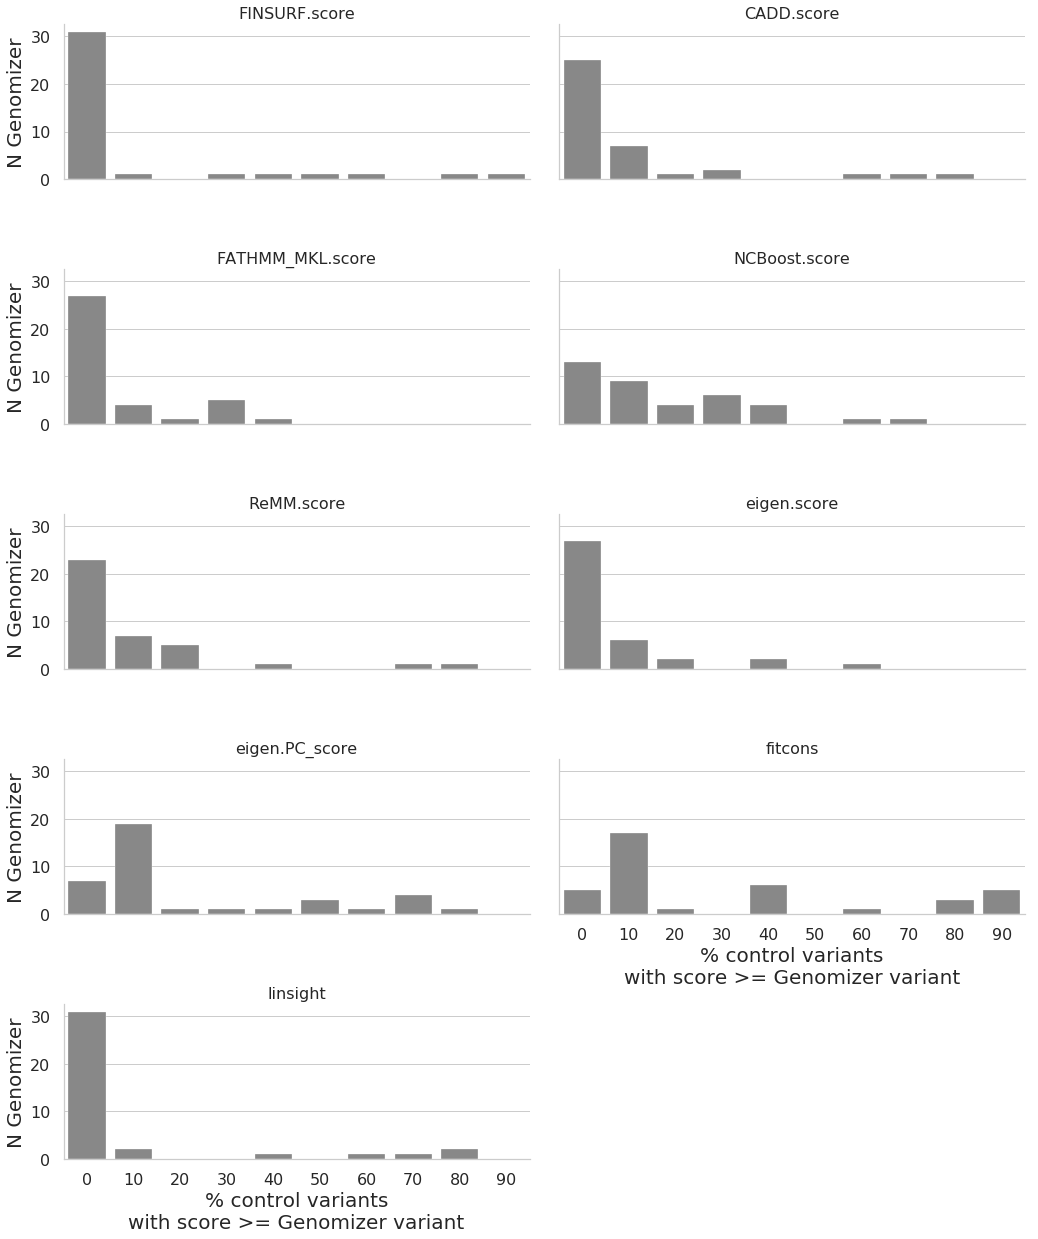

In [135]:
# Counts per bin
g = sns.catplot(data=cts_binned_per_score.reset_index().astype(int).melt(id_vars="index"),
                col="variable",
                col_wrap=2,
                x="index",
                y="value",
                color="#888888",
                aspect=2.1,
                height=3.5,
                kind="bar"
               )

for ax in g.axes:
    ax.set_title(ax.get_title().split(" = ")[1])
    if ax.get_ylabel():
        ax.set_ylabel("N Genomizer")
    
# We will rename the xlabel on the bottom axes
for ax in g.axes[-2:]:
    ax.set_xlabel("% control variants\nwith score >= Genomizer variant")

plt.show()          

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


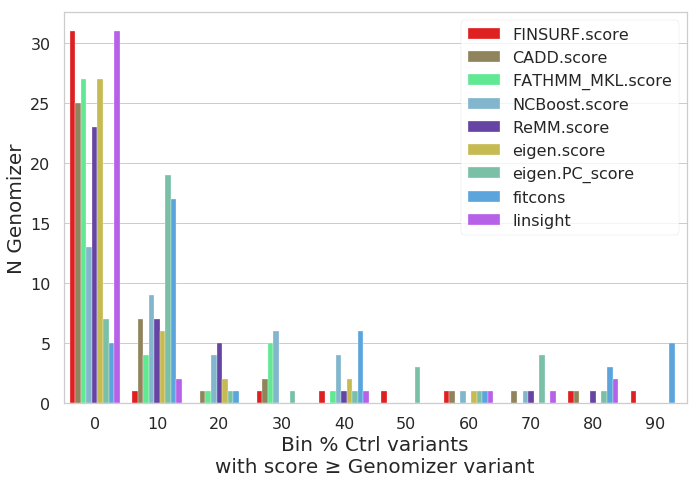

In [350]:
fig = plt.figure(figsize=(10,7))
ax1=fig.add_subplot(1,1,1)

sns.barplot(
    data=cts_binned_per_score.reset_index().astype(int).melt(id_vars="index"),
    x="index",
    y="value",
    hue="variable",
    palette=score_to_color,
    ax=ax1
)
ax1.set_ylabel("N Genomizer")
ax1.set_xlabel("Bin % Ctrl variants\nwith score ≥ Genomizer variant")
ax1.legend(bbox_to_anchor=(1,1))

plt.show()

#### Across-scores % control variants with higher score

Here we want to display each unique variant.

In [152]:
tmp_plot = tmp.assign(label=tmp.apply(lambda row: f"{row['#chrom']}:{row['ref']}>{row['alt']}\n{row['omim']}",axis=1)
                          
          ).loc[:,["label","FINSURF.score"]+score_columns
               ].melt(id_vars="label")
                      
display(tmp_plot.head(3))

,label,variable,value
0,chr11:CCG>CAA\nMIM 102200,FINSURF.score,0.000000
1,chr20:G>T\nMIM 117650,FINSURF.score,0.045455
2,chr2:A>G\nMIM 124000,FINSURF.score,0.538462


/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


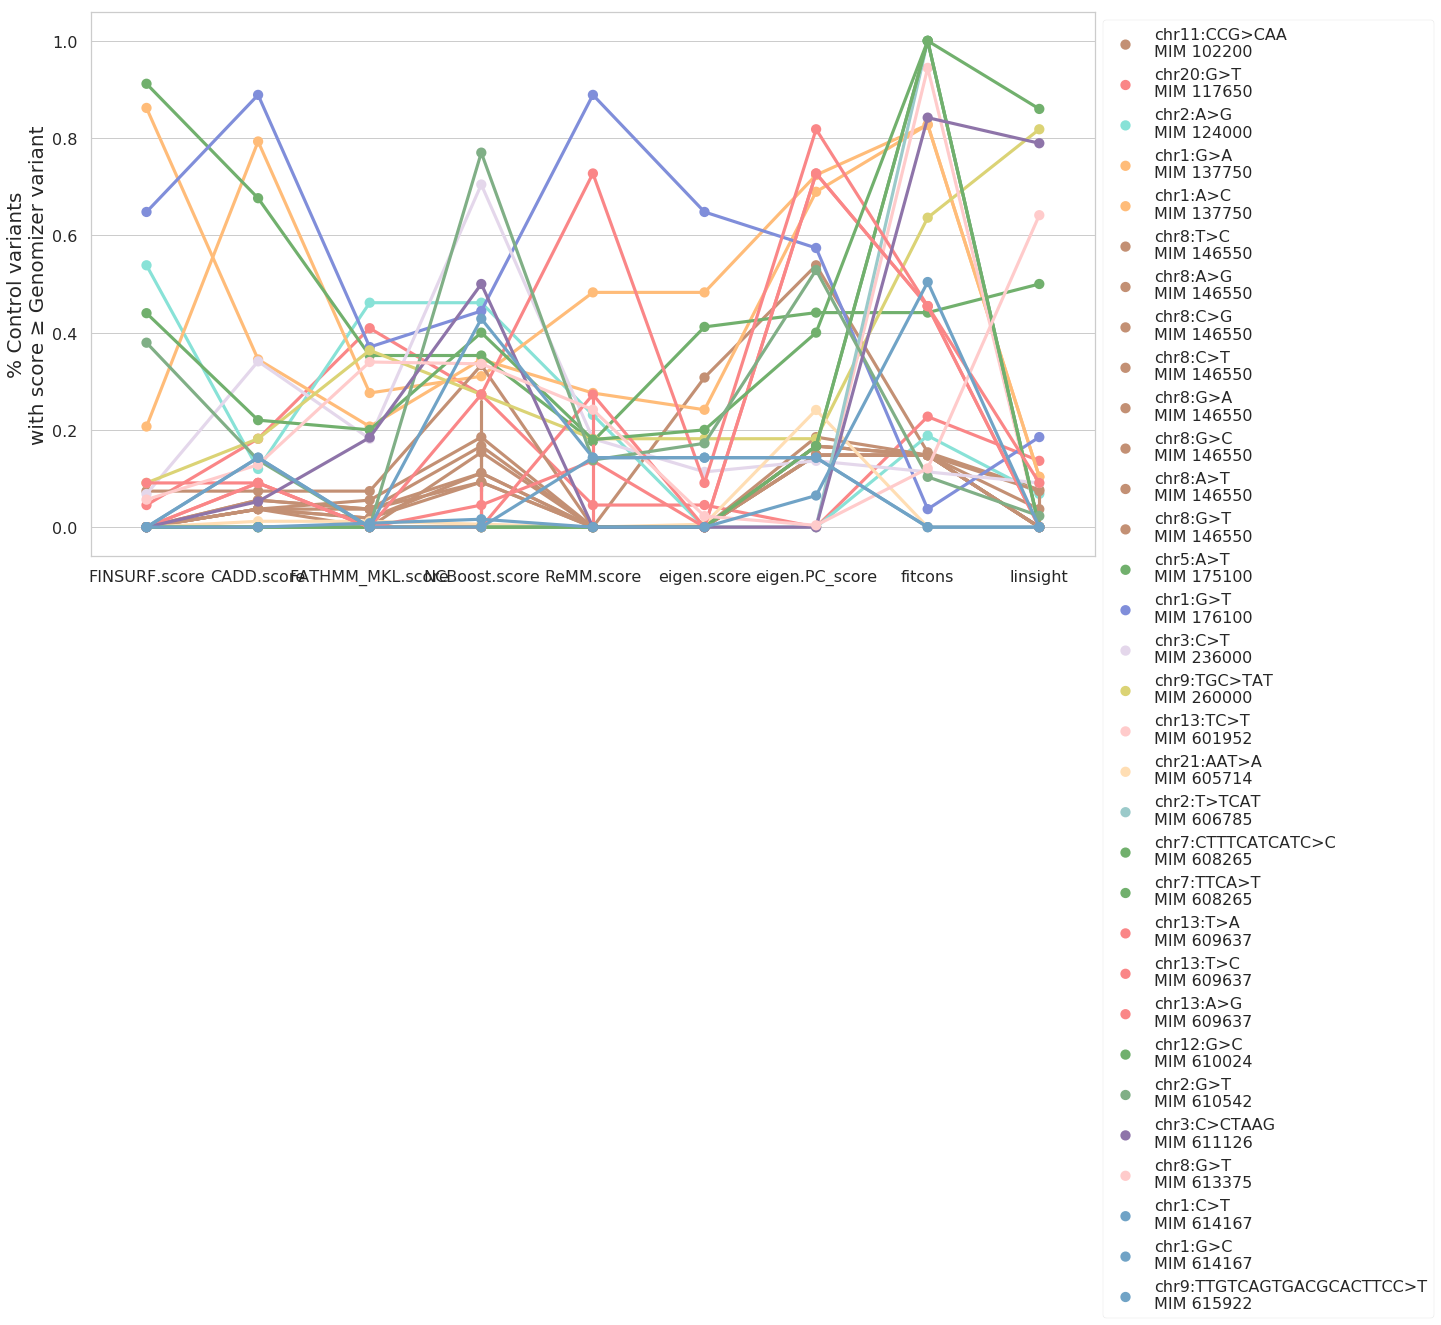

In [155]:
tmp_plot = tmp.assign(label=tmp.apply(lambda row: f"{row['#chrom']}:{row['ref']}>{row['alt']}\n{row['omim']}",axis=1)
                          
          ).loc[:,["label","FINSURF.score"]+score_columns
               ].melt(id_vars="label")
                      
display(tmp_plot.head(3))

fig = plt.figure(figsize=(18,10))
ax1 = fig.add_subplot(1,1,1)

sns.pointplot(data=tmp_plot,
              x="variable",
              y="value",
              hue="label",
              palette={label:colors_omim_complete[label.split("\n")[1]]["lowalpha"] for label in tmp_plot["label"].values
                      },
              ax=ax1
             )

ax1.legend(bbox_to_anchor=(1,1))
ax1.set_ylabel("% Control variants\nwith score ≥ Genomizer variant")
ax1.set_xlabel("")

plt.show()

Let's split per omim.

,label,omim,variable,value
0,chr11:CCG>CAA\nMIM 102200,MIM 102200,FINSURF.score,0.000000
1,chr20:G>T\nMIM 117650,MIM 117650,FINSURF.score,0.045455
2,chr2:A>G\nMIM 124000,MIM 124000,FINSURF.score,0.538462


/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


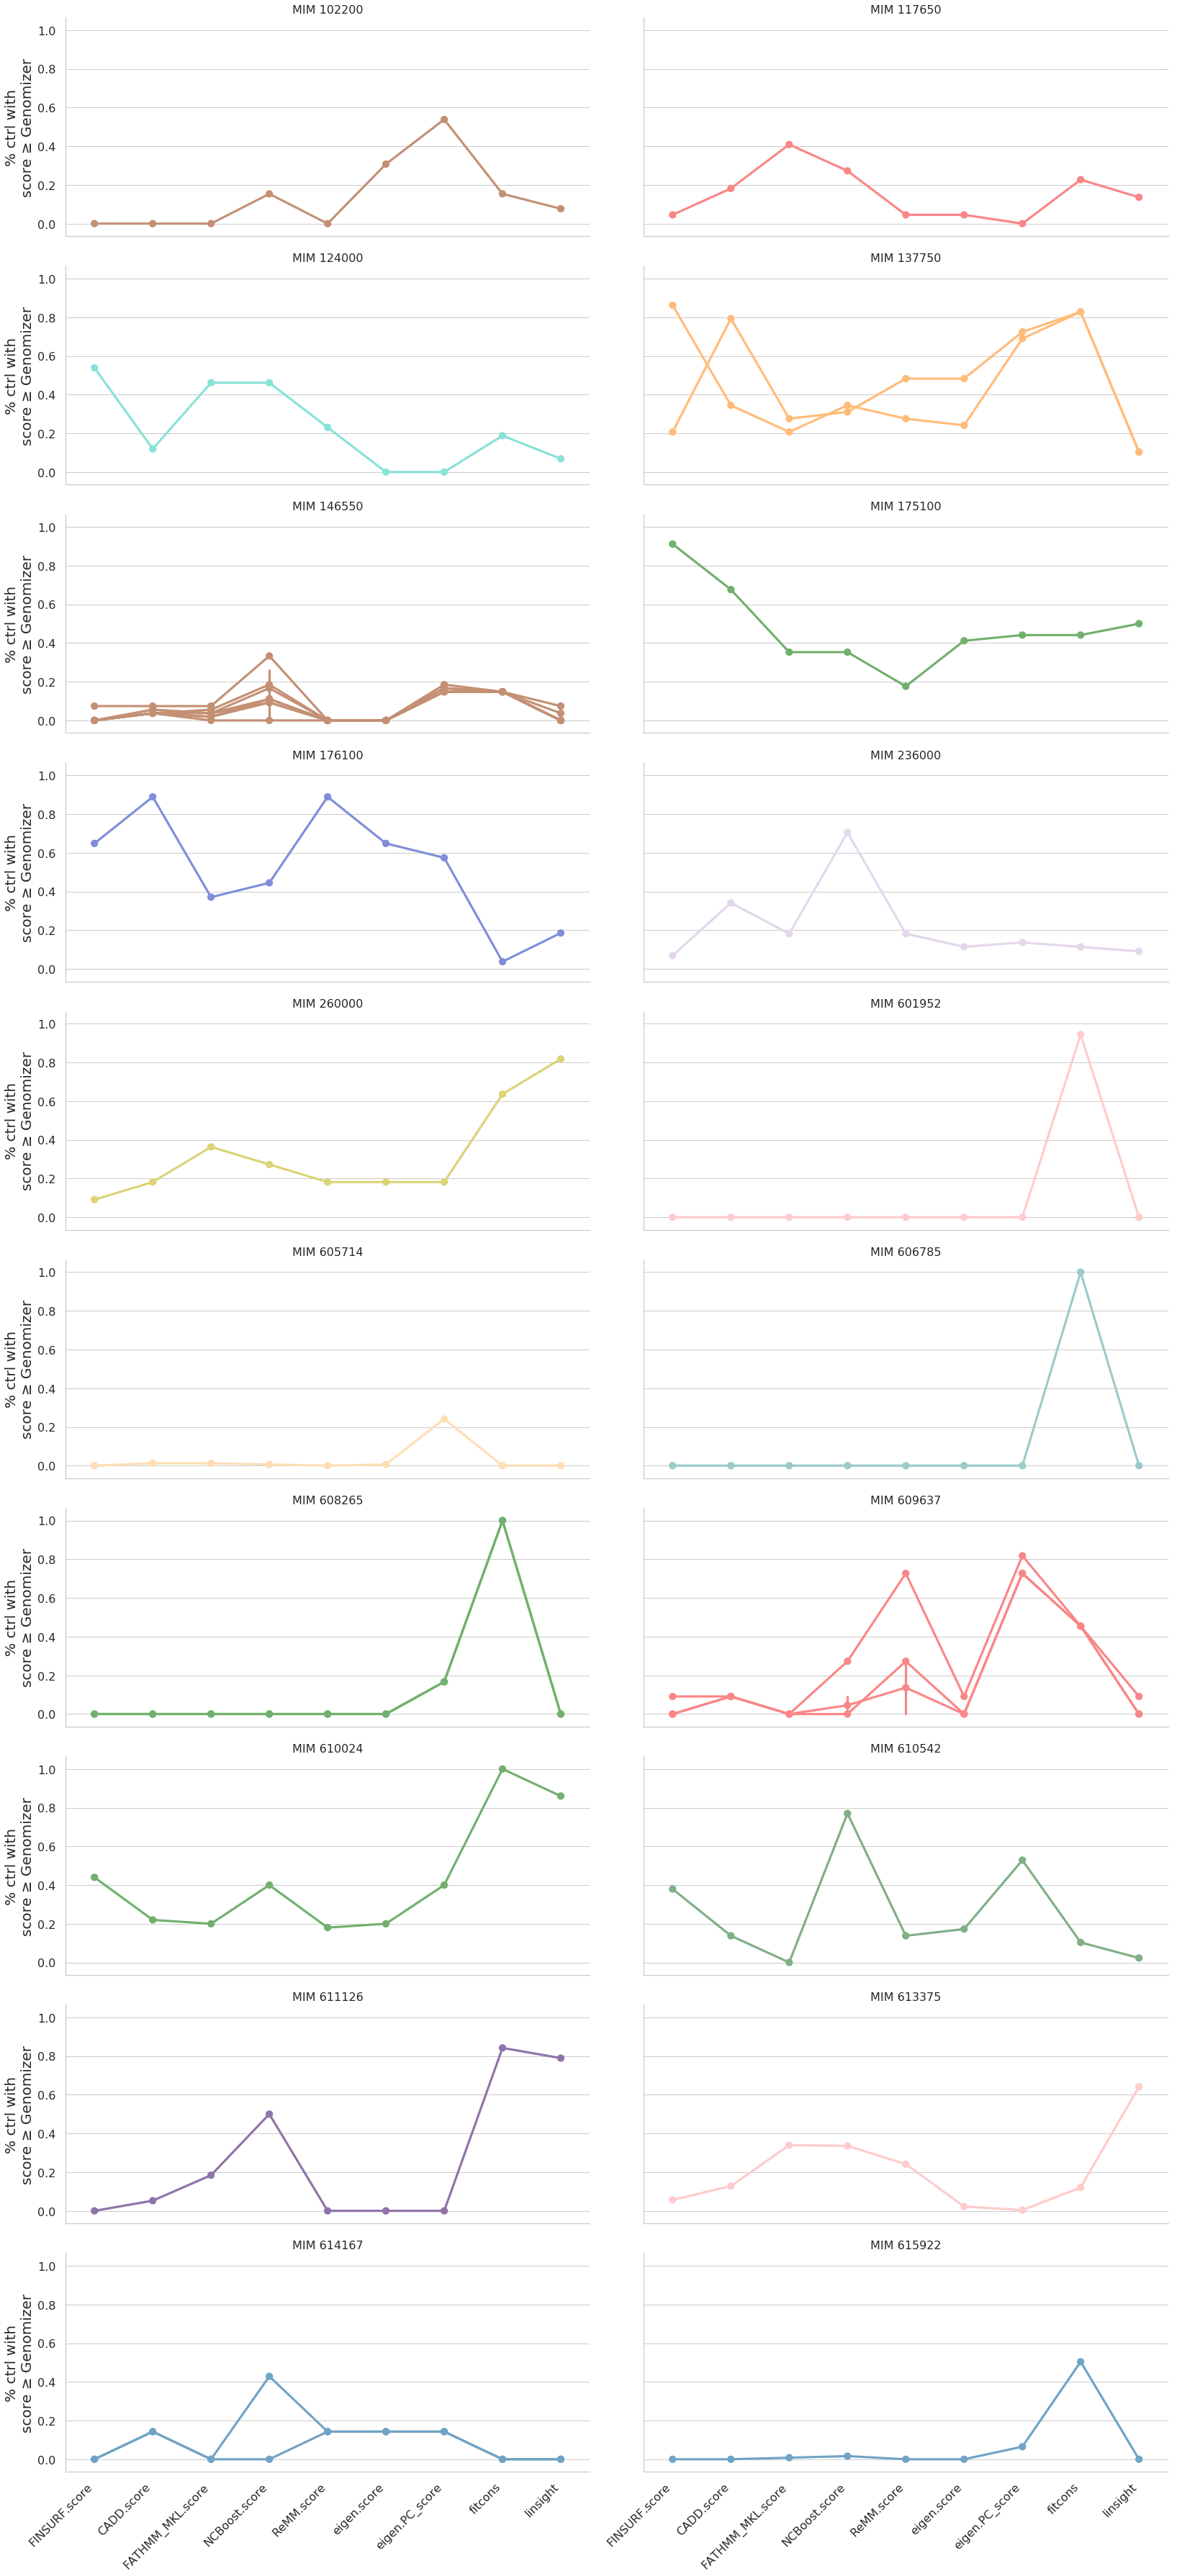

In [168]:
tmp_plot = tmp.assign(label=tmp.apply(lambda row: f"{row['#chrom']}:{row['ref']}>{row['alt']}\n{row['omim']}",axis=1)
                          
          ).loc[:,["label","omim","FINSURF.score"]+score_columns
               ].melt(id_vars=["label","omim"])
                      
display(tmp_plot.head(3))

g = sns.catplot(data=tmp_plot,
                col="omim",
                col_wrap=2,
                x="variable",
                y="value",
                hue="label",
                palette={label:colors_omim_complete[label.split("\n")[1]]["lowalpha"] for label in tmp_plot["label"].values
                          },
                kind="point",
                aspect=2.3,
                heigth=1,
                legend=False,
                )
                      
for ax in g.axes:
    ax.set_title(ax.get_title().split(" = ")[1])
    if ax.get_ylabel():
        ax.set_ylabel("% ctrl with\nscore ≥ Genomizer")                      
                      
for ax in g.axes[-2:]:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_xlabel("")
    

plt.show()

#### Pairwise scatterplots of variants percentiles

Here we focus on the positive variants (38) ; the goal is to show the percentile of the variant as calculated for each method, and compare these percentiles through pairwise scatterplots.

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


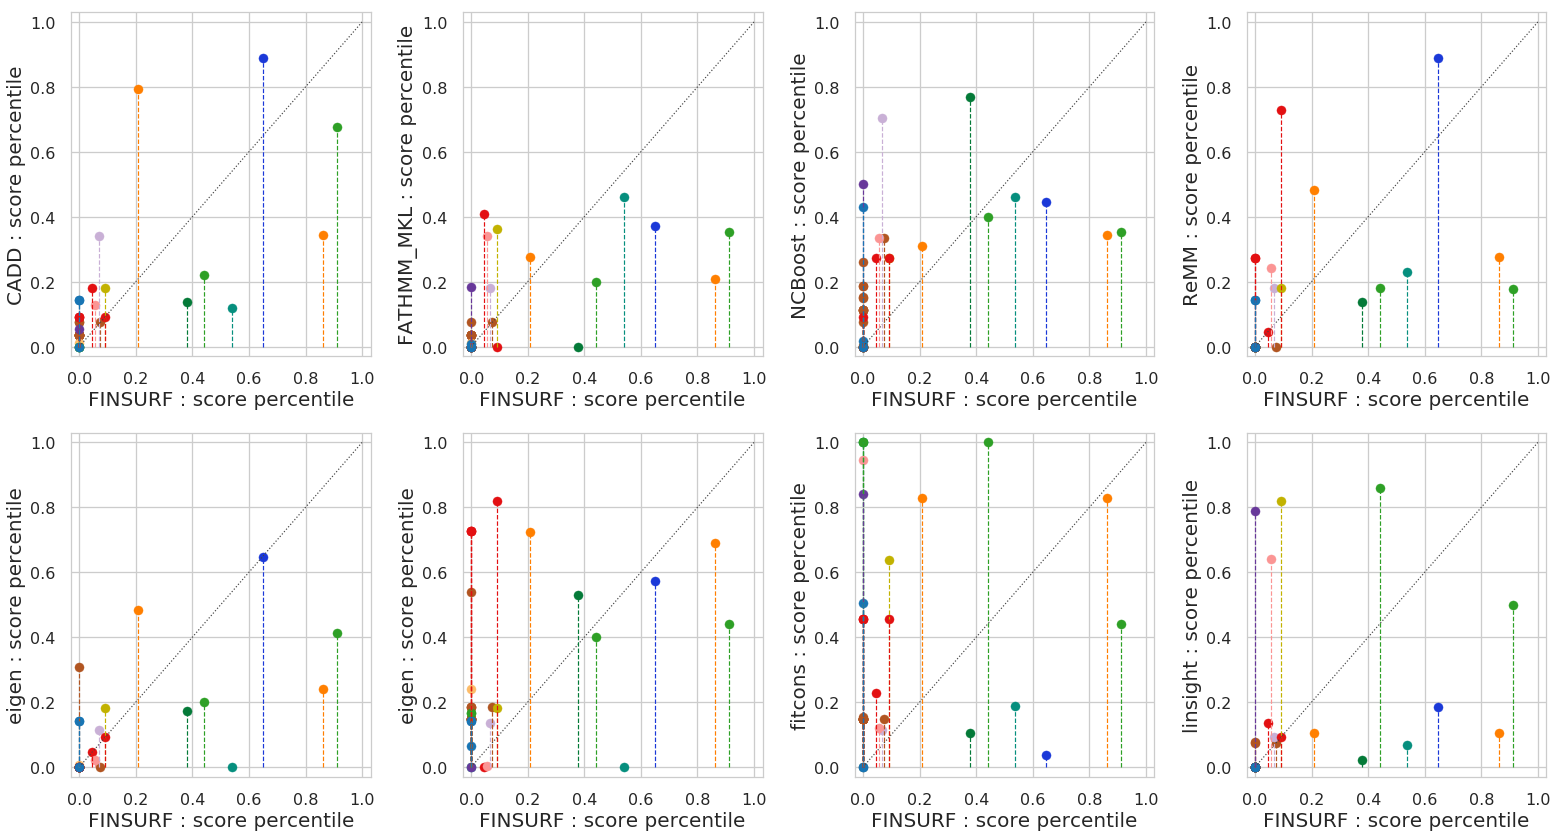

In [309]:
table_plot_tmp  = tmp.assign(label=tmp.apply(lambda row: f"{row['#chrom']}:{row['ref']}>{row['alt']}\n{row['omim']}",
                             axis=1)
                            ).loc[:,['omim','label']+["FINSURF.score"]+score_columns
                                 ]

# list of paired columns
paired_scores = list(zip(itt.repeat("FINSURF.score"),score_columns))

fig, axs = create_regular_grid_axes(N_cols=4, N_tot=len(paired_scores), height_row=6, width=22)

for ax, (sc1, sc2) in zip(axs, paired_scores):
    # This line is for reference : equal ranks between the two methods
    ax.plot((0,1),(0,1), color="#444444", linestyle="dotted",linewidth=1.2)
    
    for omim_id, sub_table in table_plot_tmp.groupby('omim'):
        ax.scatter(sub_table[sc1], sub_table[sc2],
                   color=colors_omim_complete[omim_id]['normal']
                  )
        lines = list(zip(zip(sub_table[sc1].values,itt.repeat(0)),
                         zip(sub_table[sc1].values, sub_table[sc2].values))
                    )
        for vertical_line in lines:
            ax.plot([v[0] for v in vertical_line], # list of x coords
                    [v[1] for v in vertical_line], # list of y coords
                   color=colors_omim_complete[omim_id]['normal'],
                   linestyle="--",
                   linewidth=1.2,
                  )
    ax.set_xlabel(f"{sc1.split('.')[0]} : score percentile")
    ax.set_ylabel(f"{sc2.split('.')[0]} : score percentile")
    
    # The values are percentiles here, so we can set the same limits for x and y
    ax.set_xlim(-0.03,1.03)
    ax.set_ylim(-0.03,1.03)
            
plt.show()

Problem : the "best" variants are those within the 0 percentile, and most are aggregated at (0,0) ; while the one we see the best are less well ranking variants.

#### Pairwise scatterplots of scores

Same principle as above, but this time with the raw scores.

In [313]:
tmp_table_pos_and_neg = pd.concat(results_alt_scores.values()).rename(columns={"score":"FINSURF.score"})
tmp_table_pos = tmp_table_pos_and_neg.loc[lambda df: ~df['omim'].isnull(),
                          :
                         ]

tmp_table_pos_plot = tmp_table_pos.assign(
                        label=tmp_table_pos.apply(lambda row: f"{row['#chrom']}:{row['ref']}>{row['alt']}\n{row['omim']}",
                             axis=1)
                      ).loc[:,['omim','label']+["FINSURF.score"]+score_columns
                            ]


In [314]:
tmp_table_pos_plot.head()

,omim,label,FINSURF.score,CADD.score,FATHMM_MKL.score,NCBoost.score,ReMM.score,eigen.score,eigen.PC_score,fitcons,linsight
0,MIM 102200,chr11:CCG>CAA\nMIM 102200,0.569432,0.665961,0.36606,0.153406,0.965,0.5948,1.5700,0.166803,0.149215
0,MIM 117650,chr20:G>T\nMIM 117650,0.616407,0.542876,0.12917,0.104614,0.969,1.7220,8.2090,0.089980,0.151672
0,MIM 124000,chr2:A>G\nMIM 124000,0.133346,0.475410,0.14531,0.046099,0.762,1.6880,7.3840,0.121890,0.175215
0,MIM 137750,chr1:G>A\nMIM 137750,0.072355,0.234924,0.22277,0.073556,0.594,0.3261,-0.1216,0.065670,0.252988
1,MIM 137750,chr1:A>C\nMIM 137750,0.282409,-0.197075,0.17852,0.092434,0.061,-0.1537,-0.1484,0.065670,0.304325


/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


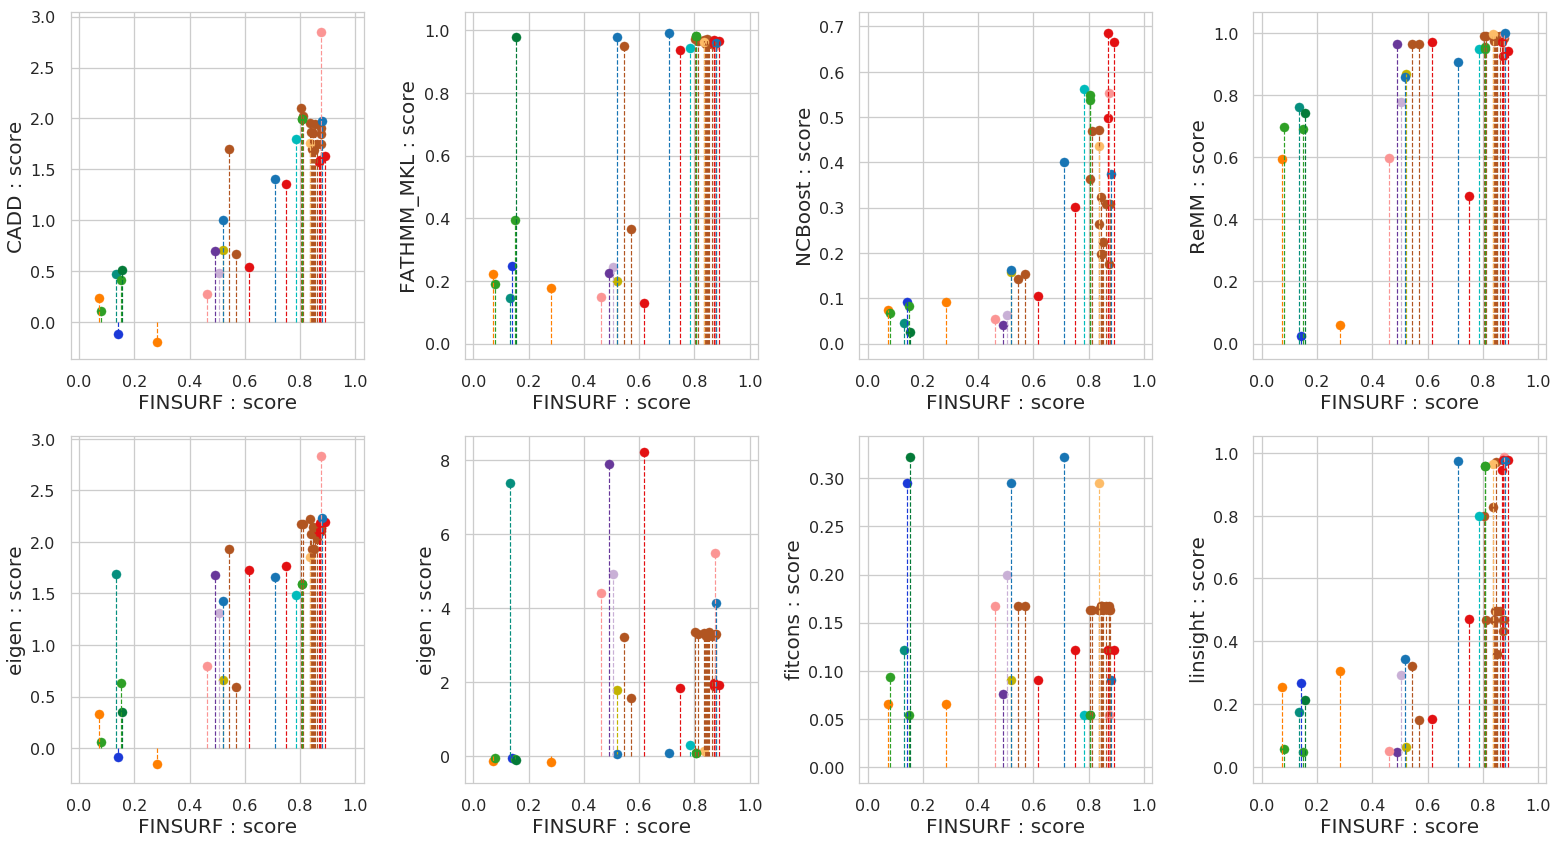

In [315]:
# list of paired columns
paired_scores = list(zip(itt.repeat("FINSURF.score"),score_columns))

fig, axs = create_regular_grid_axes(N_cols=4, N_tot=len(paired_scores), height_row=6, width=22)

for ax, (sc1, sc2) in zip(axs, paired_scores):    
    for omim_id, sub_table in tmp_table_pos_plot.groupby('omim'):
        ax.scatter(sub_table[sc1], sub_table[sc2],
                   color=colors_omim_complete[omim_id]['normal']
                  )
        lines = list(zip(zip(sub_table[sc1].values,itt.repeat(0)),
                         zip(sub_table[sc1].values, sub_table[sc2].values))
                    )
        for vertical_line in lines:
            ax.plot([v[0] for v in vertical_line], # list of x coords
                    [v[1] for v in vertical_line], # list of y coords
                   color=colors_omim_complete[omim_id]['normal'],
                   linestyle="--",
                   linewidth=1.2,
                  )
    ax.set_xlabel(f"{sc1.split('.')[0]} : score")
    ax.set_ylabel(f"{sc2.split('.')[0]} : score")
    
    # The values are scores, so we only set the (known) FINSURF score range
    ax.set_xlim(-0.03,1.03)
            
plt.show()

Problem : although now the best scoring variants are intuitively identified in the top right corner, their amount makes some of the plots slightly less readable.

#### ROC and PRC

In [224]:
import sklearn
import sklearn.metrics

In [346]:
tmp_table_pos_and_neg = pd.concat(results_alt_scores.values()).rename(columns={"score":"FINSURF.score"})
y_true = 1-tmp_table_pos_and_neg['omim'].isnull().astype(int).values

(models_comp_rocs,
 models_comp_roc_aucs,
 models_comp_prcs,
 models_comp_prc_aucs) = model_comparison_lib.compute_PRC_ROC_coordAndAUCS_single(
                                                             tmp_table_pos_and_neg,
                                                             y_true, 
                                                             ["FINSURF.score"]+score_columns
                                                            )

In [347]:
print(f"{y_true.sum()} positives, {y_true.shape[0]-y_true.sum()} negatives ({y_true.mean():.2%})")

38 positives, 1140 negatives (3.23%)


In [348]:
columns_scores = ['CADD.score',
                  'FATHMM_MKL.score',
                  'NCBoost.score',
                  'ReMM.score',
                  'eigen.score',
                  'eigen.PC_score',
                  'fitcons',
                  'linsight',
                 ]

colors_scores = ['#998953',
                 '#4aff8c',
                 '#75bbd9',
                 '#6234b3',
                 '#d9c93f',
                 '#6eccaa',
                 '#46a8f2',
                 '#bd4aff',
                ]

score_to_color = dict(zip(columns_scores,colors_scores))
score_to_color['FINSURF_HGMD']  = '#FF0000'
score_to_color['FINSURF.score'] = '#FF0000'
score_to_color['FINSURF'] = '#FF0000'
score_to_color['FINSURF_eQTLs']  = '#FF9C00'

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


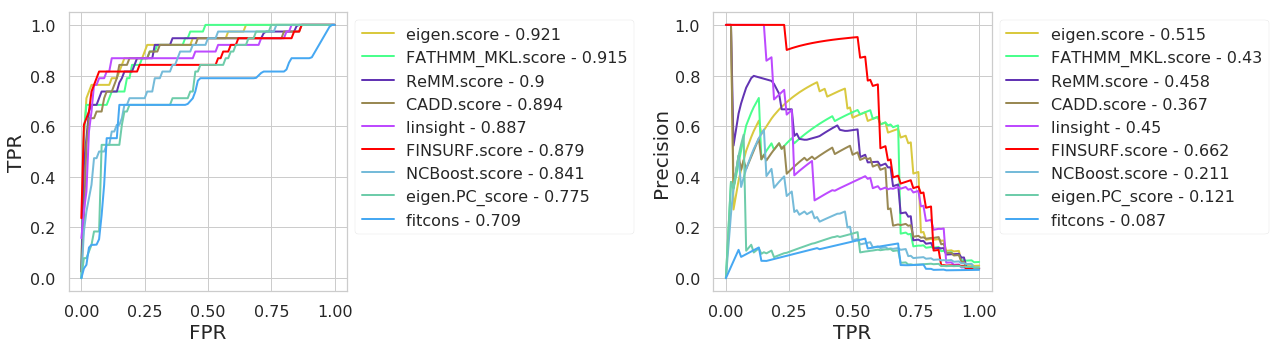

In [387]:
path_figure = "./2021-01-27_genomizer-platinum_compared-models_ROC-PRC.svg"
model_comparison_lib.plot_comparison_rocsAndPRCs(models_comp_rocs,
                                                models_comp_roc_aucs,
                                                models_comp_prcs,
                                                models_comp_prc_aucs,
                                                score_to_color,
                                                 savefig_file=path_figure
                                               )

We now try a scatter plot from the paired AUC values, to highlight the better precision of FINSURF.

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


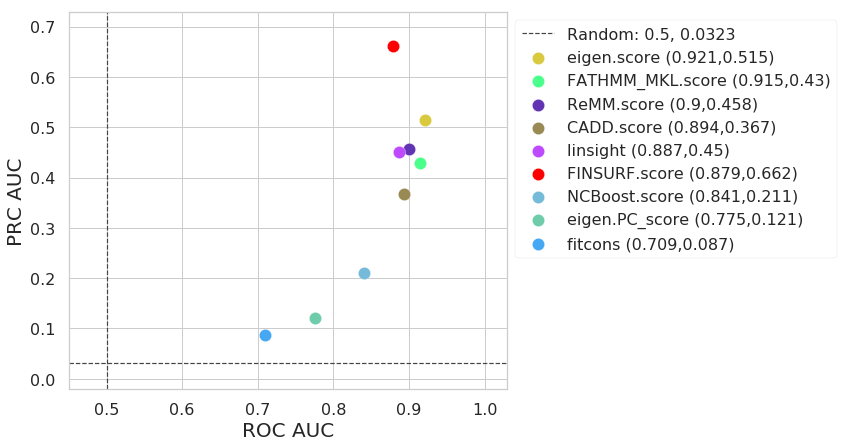

In [385]:
path_figure = "./2021-01-27_genomizer-platinum_compared-models_AUC-scatterplot.svg"
model_comparison_lib.scatterplot_aucs(models_comp_prc_aucs, models_comp_roc_aucs,
                                     score_to_color,
                                      y_true=y_true,
                                      sort_by='roc',
                                     full_range_roc=False,
                                     full_range_prc=False,
                                     show_plot=True,
                                     savefig_file=None
                                     )

#### Boxplot per method, with colored points

In [362]:
tmp_boxplot_table = tmp.loc[:,["FINSURF.score"]+score_columns
                           ].mul(100).assign(omim=tmp['omim'].values).melt(id_vars='omim')

In [363]:
tmp_boxplot_table.head(3)

,omim,variable,value
0,MIM 102200,FINSURF.score,0.000000
1,MIM 117650,FINSURF.score,4.545455
2,MIM 124000,FINSURF.score,53.846154


/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


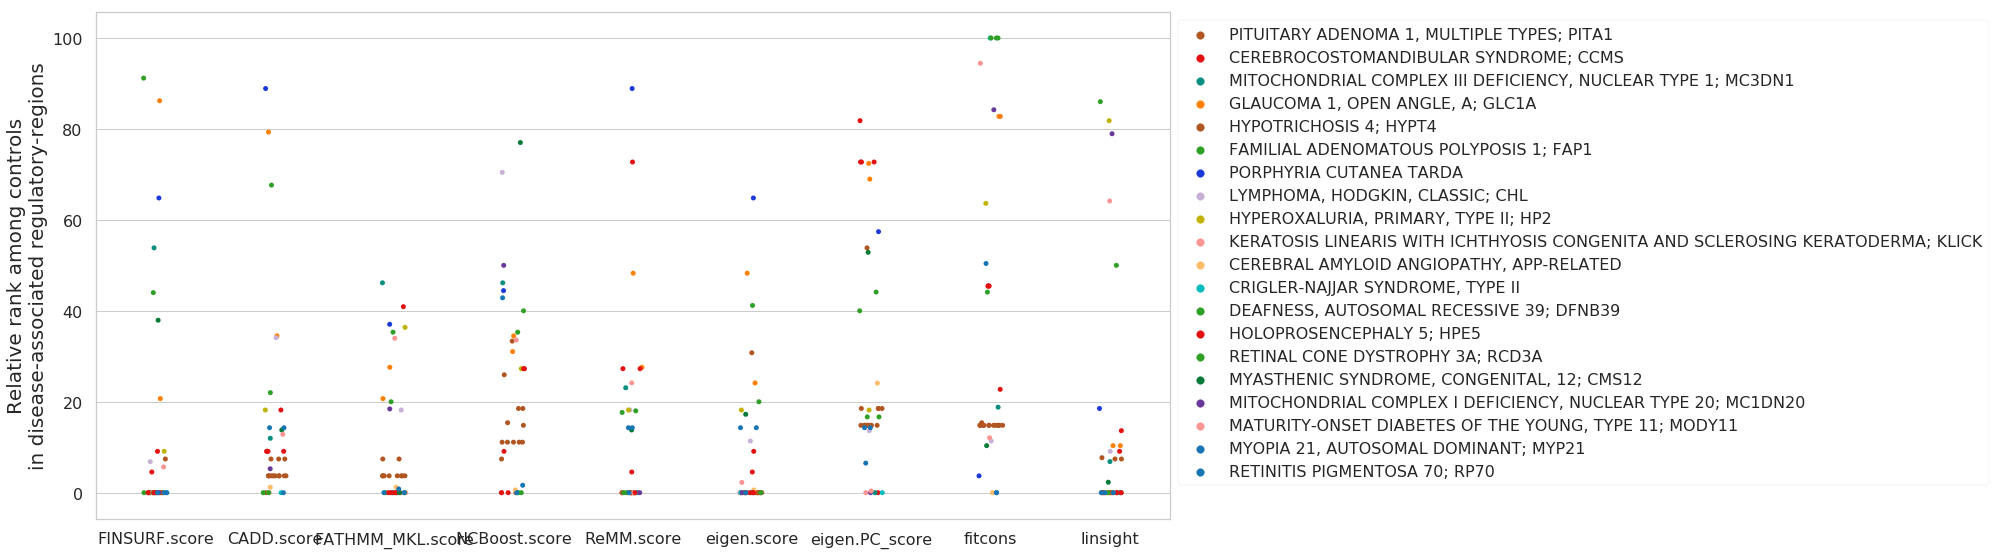

In [384]:
path_figure = "./2021-01-27_relative-rank-genomizer-platinum_compared-models.svg"

fig = plt.figure(figsize=(28,8))
ax1 = fig.add_subplot(1,1,1)
sns.stripplot(data=tmp_boxplot_table,
              x='variable',
              y='value',
              hue='omim',
              palette={k:v['normal'] for k,v in colors_omim_complete.items()},
              ax=ax1
             )
ax1.set_ylabel('Relative rank among controls\nin disease-associated regulatory-regions')
ax1.set_xlabel('')
l = ax1.legend(bbox_to_anchor=(1,1))
_ = [t.set_text(json_omim_str[t.get_text()]['title']) for t in l.get_texts()]
plt.savefig(path_figure)
plt.show()